## Test for random sequence of data

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd.functional import hessian
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm 
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import os
import copy
from torch.nn.utils import _stateless

batch_size = 1
num_workers = 1
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device

details = {}
details['use_db'] = 'mnist'
details['result_root_dir']='results/t0/'
details['result_path']='try1_t6_r1.5'
details['ratio'] = 1.5
details['book_keep_freq'] = 20
details['g_times'] = 10
details['g_epochs'] = 1
details['alpha_0']= 0.001
details['freq_reduce_by'] = 20
details['freq_reduce_after'] = 100

details['training_step_limit'] = 100000 ## this is to train for max updates per epochs
details['stop_hess_computation'] = 20000 ## Stop computing hessian after calculated these many times

details['g_weight'] = int(details['ratio']*20000/(784+10))
print(f'selected weight:{details["g_weight"]}')

with open(details['result_root_dir']+'details_'+details['result_path']+'.txt', 'w+') as f:
    for key, val in details.items():
        content = key + ' : '+str(val) + '\n'
        f.write(content)
        
torch.manual_seed(3407)
np.random.seed(3407)
torch.cuda.manual_seed_all(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)
# os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

train_data_all = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data_all = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
# print(f'train data:{train_data}')
# print(f'test data:{test_data}')

def get_random_subset(train_data_all, test_data_all):    
    # train_indices = torch.arange(20000)
    test_indices = torch.arange(1000)
    train_indices = torch.randint(60000-1, (20000,))
    # print(f'train indices:{train_indices[:10]}')
    train_data = data_utils.Subset(train_data_all, train_indices)
    test_data = data_utils.Subset(test_data_all, test_indices)
    # print(f'train data:{train_data}')
    # print(f'test data:{test_data}')
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(0)

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=256,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    print(f'train data size:{len(train_loader.dataset)}')
    print(f'test data size:{len(test_loader.dataset)}')
    # X_mat, y_mat = torch.Tensor(len(train_loader.dataset),784), torch.Tensor(len(train_loader.dataset)).long()
    # for i, (data, label) in enumerate(train_loader):
    #     X_mat[i] = data.flatten()
    #     y_mat[i] = label.flatten()
    # print(f'X_mat shape:{X_mat.shape}, y_mat shape:{y_mat.shape}')
    return train_loader, test_loader #, X_mat, y_mat


class Net(nn.Module):

    def __init__(self, input_features, hidden_layers, output_size):
        super(Net, self).__init__()
        self.layers = len(hidden_layers) + 1
        self.total_params_len = 0
        self.fc1 = nn.Linear(input_features, hidden_layers[0])
        self.total_params_len += input_features*hidden_layers[0] + hidden_layers[0]
        self.fc2 = nn.Linear(hidden_layers[0], output_size)
        self.total_params_len += hidden_layers[0]*output_size + output_size
        
        ### Others required params
        self.param_list = []

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        # print('x shape in forward',x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def fit(self, X, Y, X_val, Y_val, epochs, batch_size=1, **kwargs):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters())
        

class Train_nn:
    
    def __init__(self, input_features, hidden_layers, output_size, lr):
        self.model = Net(input_features, hidden_layers=hidden_layers, output_size=output_size)
        self.model.to(device)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda= lambda it: 1/(it+1))
        
    def get_loss(self, X, y, params=None):
        # if params is not None:
        assert False, "Model not initialized with given params"
        op = self.model(X)
        loss = self.loss_fn(pred, y)
        return loss
    
    def get_gradient(self):
        params = (self.model.parameters())
        grad_norm_sq = torch.tensor(0, dtype=float).to(device)
        # print('grad Norm init:', grad_norm_sq)
        for param in self.model.parameters():
            temp = param.grad.data.pow(2).sum()
            # print(f'param grad norm \n\tsum:{temp.data}')#,\n\tshape:{param.shape}')
            grad_norm_sq += temp
            
        return grad_norm_sq.sqrt().cpu()
    
    def try_operator_norm(self, hess_mat):
        for i in len(hess_mat):
            for j in len(hess_mat[0]):
                torch.unsqueeze(hess_mat[i][i],0)
        hess_tensor_dim = list(hess_mat[0][0].shape)
        hess_tensor_dim += [n*2,n*2]
        hess_mat_np = np.zeros(shape=hess_tensor_dim)
        hess_tensor = torch.tensor(hess_mat_np)
        torch.cat(hess_mat, out=hess_tensor)
        
        hess_mat.reshpe(n*2,n*2)
        hess_norm = torch.linalg.norm(hess_mat, 2)
        assert False, "Not working"
    
    def get_hessian(self, X, y):
        prev_params = copy.deepcopy(list(self.model.parameters()))
        n = self.model.layers
        def local_model(*params):
            # print(f'len of params:{len(params)}')
            # print(f'shape of params[0]:{params[0].shape}')
            # with torch.no_grad():
            #initialize model with given params
            i = 0
            for i, param in enumerate(self.model.parameters()):
                param.data = params[i]
            pred = self.model(X)
            loss = self.loss_fn(pred, y)
            # print(f'loss type:{type(loss)}')
            return loss
        p =list(self.model.parameters())
        hess_mat = hessian(local_model, tuple(p))
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        
        # print(f'Hess mat len:{len(hess_mat)}')
        # print(f'Hess mat[0] len:{len(hess_mat[0])}')
        # print(f'Hess mat[0][0] shape:{hess_mat[0][0].shape}')
        
        hess_norm = hess_norm.sqrt()
        # print(f'hess norm:{hess_norm}')
        
        # Reinitialize the original params to model
        for i, param in enumerate(self.model.parameters()):
                param.data = prev_params[i]
        
        return hess_norm
    
    def get_hessianv2(self, X,y):
        names = list(n for n, _ in self.model.named_parameters())
        def loss_fun_hess(*params):
            out: torch.Tensor = _stateless.functional_call(self.model, {n: p for n, p in zip(names, params)}, X)
            local_loss = self.loss_fn(out, y)
            return local_loss
        hess_mat = hessian(loss_fun_hess, tuple(self.model.parameters()))
        # print(f'len of hess mat:{len(hess_mat)}')
        # print(f'hess_mat[0] shape:{len(hess_mat[0])}')
        # print(f'hess_mat[0][0] shape:{hess_mat[0][0].shape}')
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        hess_norm = hess_norm.sqrt()
        # print(f'v2 hess norm{hess_norm}')
        return hess_norm.cpu()
        
    def fit(self, train_loader, test_loader, epochs, store_grads=False, store_hessian=False, store_gen_err=False, store_weights=False, store_pt_loss=True, store_freq = 20, freq_reduce_by=None, freq_reduce_after=None):
        
        ## For Book keeping results ##
        self.grads_norms = []
        self.param_list = []
        self.hess_norms = []
        self.gen_err = []
        self.train_loss = []
        self.val_loss = []
        self.point_loss = []
        ## Initializing values ##
        terminate_training = False
        store_count = 0
        
        for epoch in tqdm(range(epochs), total=epochs, unit="epoch", disable=True):
            if terminate_training == True:
                break
            for batch, (X, y) in tqdm(enumerate(train_loader), total=len(train_loader), unit='batch'):
                # if batch>300:
                #     terminate_training = True
                #     break
                
                X, y =X.to(device), y.to(device)
                pred = self.model(X)
                loss = self.loss_fn(pred, y)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                ## Saving point loss
                if store_pt_loss and (batch%store_freq==0):
                    self.point_loss.append(loss.item())
                    
                ## Saving the weights
                if store_weights and (batch%store_freq==0):
                    current_params = tuple(self.model.parameters())
                    self.param_list.append(current_params)
                
                ## computing and saving the gradient
                if store_grads and (batch% store_freq == 0):
                    # store_count += 1
                    # # print(f'\tstore_freq:{store_freq}, batch:{batch}')
                    # if store_count%freq_reduce_after==0:
                    #     store_freq += freq_reduce_by
                    #     # print(f'store freq:{store_freq}, batch:{batch}')
                    grad_norm_per_update = self.get_gradient()
                    # print('\tgrad norm:', grad_norm_per_update)
                    self.grads_norms.append(grad_norm_per_update)
                    
                ## computing and saving hessian
                if store_hessian and (batch% store_freq==0):
                    #assert False, "Not implemented"
                    self.optimizer.zero_grad()
                    self.hess_norms.append(self.get_hessianv2(X,y))
                    store_count += 1
                    if store_count%freq_reduce_after==0:
                        store_freq += freq_reduce_by
                
                ## computing and storing the generalization error
                if store_gen_err and (batch% store_freq == 0):
                    assert False, "fix reducing freq to get it working"
                    train_loss, test_loss, point_loss=0, 0, 0
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(train_loader):
                            # if sub_batch> batch: # only taking the encountered points to calculate train loss
                            #     break
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            train_loss += self.loss_fn(pred_local, y_local).item()
                    train_loss = train_loss/(batch+1)
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(test_loader):
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            test_loss += self.loss_fn(pred_local, y_local).item()
                    test_batch_size = len(test_loader)
                    # print(f"Number of batches in test:{len(test_loader)}")
                    test_loss = test_loss/ len(test_loader)
                    self.train_loss.append(train_loss)
                    self.val_loss.append(test_loss)
                
                if batch % 10000 == 0:
                    loss, current = loss.item(), batch * len(X)
                    correct = 0
                    test_loss = 0
                    with torch.no_grad():
                        for X, y in test_loader:
                            X, y = X.to(device), y.to(device)
                            pred = self.model(X)
                            test_loss += self.loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                    acc = 100*correct/len(test_loader.dataset)
                    print(f"\taccuracy:{acc}")#, at batch:{batch}")
                    print(f"\tloss: {loss:>7f}")
                
                    # print(f'Learning rate:{self.scheduler.get_last_lr()}')
                self.scheduler.step()
            
def exp_get_lp_sm(train_data_all, test_data_all, op_features, weight = 10, times = 8, epochs = 1, root_dir='', path=None, clear_file = True, freq_reduce_by=10, freq_reduce_after=100):
    grad_list        = []
    hess_norm_list   = []
    if path is not None:
        grad_file_path = root_dir+'grad_'+path
        hess_file_path = root_dir+'hess_'+path
        # gen_file_path = root_dir+'gen_'+path
        if clear_file:
            with open(grad_file_path, 'w+') as f:
                f.write('')
            with open(hess_file_path, 'w+') as f:
                f.write('')
            
    for t in range(times):
        train_loader, test_loader = get_random_subset(train_data_all, test_data_all)
        print(f'Time:{t}')
        train_model = Train_nn(784, [weight], op_features, lr= details['alpha_0'])
        train_model.fit(train_loader, test_loader, epochs=epochs, store_grads=True, store_hessian=True, store_freq=details['book_keep_freq'],  store_gen_err=False, store_pt_loss=False, store_weights=False, freq_reduce_by = freq_reduce_by, freq_reduce_after=freq_reduce_after)
        
        with open(grad_file_path,'a+') as f:
            f.write(' '.join([str(grad) for grad in train_model.grads_norms]) + '\n')
        with open(hess_file_path,'a+') as f:
            f.write(' '.join([str(hess) for hess in train_model.hess_norms]) + '\n')
        
        hess_norm_list.append(train_model.hess_norms)
        grad_list.append(train_model.grads_norms)
         
    return grad_list, hess_norm_list

grad_list, hess_norm_list = exp_get_lp_sm(train_data_all, test_data_all, op_features=10, 
              weight=details['g_weight'], times=details['g_times'], 
              epochs=details['g_epochs'], root_dir=details['result_root_dir'], 
              path=details['result_path'], freq_reduce_by=details['freq_reduce_by'], 
              freq_reduce_after=details['freq_reduce_after'])


selected weight:37
train data size:20000
test data size:1000
Time:0


  0%|          | 0/20000 [00:00<?, ?batch/s]

	accuracy:4.9
	loss: 2.361315


KeyboardInterrupt: 

## EXP3 plot results

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
def get_exp_details(root_dir, path):
    result_details={}
    details_path = root_dir+ 'details_'+ path + '.txt'
    with open(details_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        key, val = line[:-1].split(':')
        key, val = key.strip(' '), val.strip(' ')
        if key in ['ratio', 'alpha_0']:
            val = float(val)
        if key in ['Times', 'Weights', 'Epochs', 'book_keep_freq', 'g_times', 'g_epochs','g_weight', 'freq_reduce_by', 'freq_reduce_after']:
            val = int(val)
        result_details[key] = val
    return result_details

def get_exp_results(r_det, train_size=20000):
    root_dir = r_det['result_root_dir']
    path = r_det['result_path']
    grad_file_path = root_dir+'grad_'+path
    hess_file_path = root_dir+'hess_'+path
    gen_file_path  = root_dir+'gen_'+path
    
    # print(result_details)
    grad_list    = []
    hess_list    = []
    gen_err_list = []
    
    with open(grad_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(') ')
        # print('tensors',tensors)
        t_list = [float(t[7:].split(' ')[0][:-1]) for t in tensors]
        # print('grad_list_i length:',len(t_list))
        grad_list.append(t_list)
    
    with open(hess_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(' ')
        # print('tensors',tensors)
        t_list = [float(t[7:-1]) for t in tensors]
        # print('hess_list_i length:',len(t_list))
        hess_list.append(t_list)
    hess_list = np.array(hess_list)
    grad_list = np.array(grad_list)
    print('hess list shape:',hess_list.shape)
    print('grad list shape:',grad_list.shape)
    K_g = np.max(np.mean(np.array(grad_list), 0))
    L_g = np.max(np.mean(np.array(hess_list), 0))
    
    book_keep_freq = r_det['book_keep_freq']
    freq_reduce_after = r_det['freq_reduce_after']
    freq_reduce_by = r_det['freq_reduce_by']
    x_values = []
    count_keep = 0
    for i in range(train_size):
        if i%book_keep_freq==0:
            x_values.append(i+1)
            count_keep+=1
            if count_keep%freq_reduce_after==0:
                book_keep_freq+=freq_reduce_by
    
    return grad_list, hess_list, K_g, L_g, x_values

def plot_exp_data(root_dir_list, path_list, ratios, save_fig=False, train_size=20000):
    grad_mean_list = []
    grad_df_list = []
    grad_err_list  = []
    hess_mean_list = []
    hess_df_list = []
    hess_err_list  = []
    data = {}
    for root_dir, path, ratio in zip(root_dir_list, path_list, ratios):

        res_details = get_exp_details(root_dir, path)
        grad_list, hess_list, K_g, L_g, x_values = get_exp_results(res_details, train_size)
        grad_list_m = np.max(grad_list,1)
        hess_list_m = np.max(hess_list,1)
        # K_g = np.percentile(np.mean(grad_list, 0),90)
        # L_g = np.percentile(np.mean(hess_list, 0),90)
        
        # K_g = np.max(np.mean(grad_list, 1))
        # L_g = np.max(np.mean(hess_list, 1))
        # print('grad_list shape',grad_list_m.shape)
        # print('grad_list ',grad_list_m)
        # print(f'K_g:{K_g}, L_g:{L_g}')
        grad_mean, grad_err = np.mean(grad_list_m), np.std(grad_list_m)
        hess_mean, hess_err = np.mean(hess_list_m), np.std(hess_list_m)
        grad_mean_list.append(grad_mean)
        grad_err_list.append(grad_err)
        hess_mean_list.append(hess_mean)
        hess_err_list.append(hess_err)
        
        for run_id in range(len(grad_list)):
            for epoch in range(len(grad_list[run_id])):
                grad_df_list.append({'key':int(train_size*ratio), 'run_id': run_id, 'epoch':epoch, 'val': grad_list[run_id][epoch]})
                                      
        for run_id in range(len(hess_list)):
            for epoch in range(len(hess_list[run_id])):
                hess_df_list.append({'key':int(train_size*ratio), 'run_id': run_id, 'epoch':epoch, 'val': hess_list[run_id][epoch]})
        
        # plt.errorbar(x_values, np.mean(grad_list,0),np.std(grad_list,0), label='ratio:'+str(ratio))
    df1 = pd.DataFrame(grad_df_list)
    df2 = pd.DataFrame(hess_df_list)
    
    temp_df1 = df1.groupby(['key','run_id'])['val'].max().reset_index()
    temp_df2 = df2.groupby(['key','run_id'])['val'].max().reset_index()
    # temp_df1 = df1
    # temp_df2 = df2
    grad_mean_list = np.array(grad_mean_list)
    grad_err_list = np.array(grad_err_list)
    hess_mean_list = np.array(hess_mean_list)
    hess_err_list = np.array(hess_err_list)
    x_values = [str(int(train_size*t)) for t in ratios]
    fig, ax = plt.subplots(figsize=(12,7))
    sns.pointplot(data = temp_df1, x='key',y='val', estimator=np.mean, ax=ax, label='Lipschitz const.', color='orange', errwidth=0)
    ax.fill_between(x_values, grad_mean_list-grad_err_list, grad_mean_list+ grad_err_list, color='orange', alpha=.3)
    plt.xlabel('Number of parameters', fontsize = 24)
    plt.ylabel('Lipschitz constant', fontsize = 24)    
    sns.set_context("talk")
    sns.set(font='sans-serif', style='whitegrid', font_scale=2, rc={"lines.linewidth": 2, "lines.markersize":10})
    plt.title('Mnist dataset', fontsize=24)
    if save_fig:
        plt.savefig('e3_Lipschitz_constant_mnist.png')
    
    fig, ax = plt.subplots(figsize=(12,7))
    sns.pointplot(data = temp_df2, x='key',y='val', ax=ax, label='Smoothness const.', color='green', errwidth=0)
    ax.fill_between(x_values, hess_mean_list-hess_err_list, hess_mean_list+ hess_err_list, color='green', alpha=.3)
    plt.xlabel('Number of parameters', fontsize = 24)
    plt.ylabel('Smoothness constant', fontsize = 24)    
    sns.set_context("talk")
    sns.set(font='sans-serif', style='whitegrid', font_scale=2, rc={"lines.linewidth": 2, "lines.markersize":10})
    # plt.show()
    plt.title('Mnist dataset', fontsize=24)
    if save_fig:
        plt.savefig('e3_Smoothness_constant_mnist.png')
    return df1, df2

hess list shape: (6, 396)
grad list shape: (6, 400)
hess list shape: (6, 396)
grad list shape: (6, 400)
hess list shape: (6, 396)
grad list shape: (6, 400)
hess list shape: (6, 396)
grad list shape: (6, 400)
hess list shape: (6, 396)
grad list shape: (6, 400)


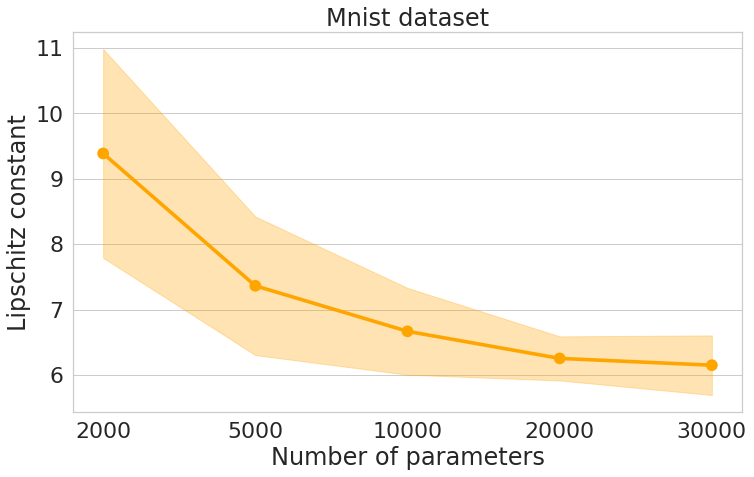

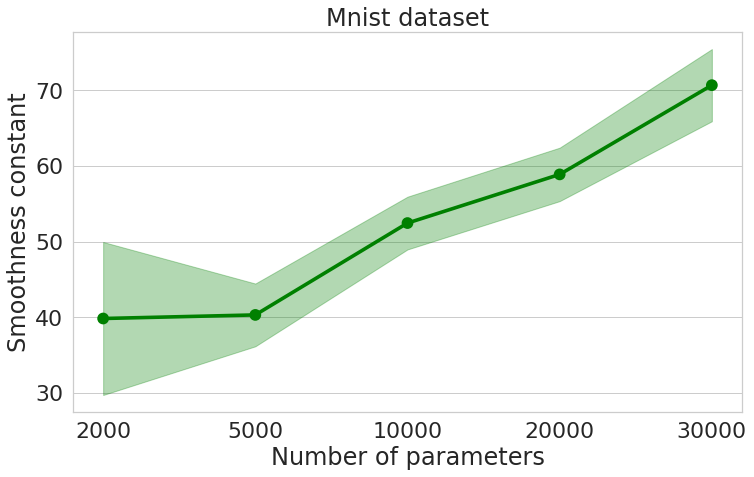

In [103]:
root_dir_list = ['results/t2/','results/t2/','results/t2/','results/t2/','results/t2/','results/t2/']
path_list = ['try1_t6_r.1', 'try1_t6_r.25', 'try1_t6_r.5','try1_t6_r.75', 'try1_t6_r1.0', 'try1_t6_r1.5']
ratios = [0.1, 0.25, 0.5, 1, 1.5]
grad_df, hess_f= plot_exp_data(root_dir_list[:], path_list[:], ratios[:], save_fig=False)

hess list shape: (8, 100)
grad list shape: (8, 100)
hess list shape: (8, 100)
grad list shape: (8, 100)
hess list shape: (8, 100)
grad list shape: (8, 100)
hess list shape: (8, 100)
grad list shape: (8, 100)
hess list shape: (8, 100)
grad list shape: (8, 100)


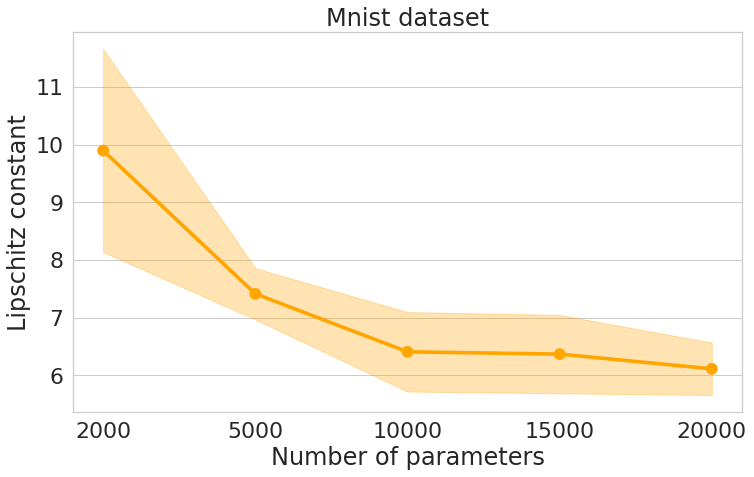

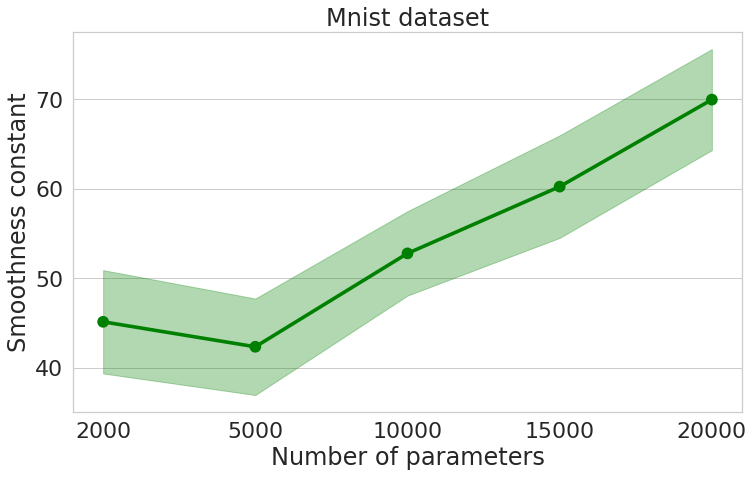

In [109]:
root_dir_list = ['results/t4/','results/t4/','results/t4/','results/t4/','results/t4/']
path_list = ['try1_t6_r1.0', 'try1_t6_r2.5', 'try1_t6_r5','try1_t6_r7.5', 'try1_t6_r10']
ratios = [1.0, 2.5, 5.0, 7.5, 10.0]
grad_df, hess_f= plot_exp_data(root_dir_list[:], path_list[:], ratios[:], save_fig=False, train_size=2000)

In [183]:
root_dir='results/t2/'
path='try1_t6_r1.5'

## Reading the plot

In [93]:
import numpy as np
import matplotlib.pyplot as plt

In [134]:
def get_exp_details(root_dir, path):
    result_details={}
    details_path = root_dir+ 'details_'+ path + '.txt'
    with open(details_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        key, val = line[:-1].split(':')
        key, val = key.strip(' '), val.strip(' ')
        if key in ['ratio', 'alpha_0']:
            val = float(val)
        if key in ['Times', 'Weights', 'Epochs', 'book_keep_freq', 'g_times', 'g_epochs','g_weight', 'freq_reduce_by', 'freq_reduce_after']:
            val = int(val)
        result_details[key] = val
    return result_details

In [135]:
def our_bound_computatio(K_g, L_g, m, t, alpha_0, way='normal'):
    beta = 1
    alpha_lg = alpha_0*L_g
    print('alpha_0 L_g (<=0.25?):',alpha_lg)
    if way == 'normal':
        F = np.power(t/m, 2*alpha_lg)
        F = F*np.power(2, t/m)
        # print('F', F)
        beta = (1+alpha_lg)*np.power(K_g,2)/L_g
        beta = beta* F/(np.power(m, 1-2*alpha_lg))
    est_gen_err = beta + 2*beta*np.sqrt(m)
    return est_gen_err

def get_bound(r_det, K_g, L_g):
    alpha_0 = r_det['alpha_0']
    book_keep_freq = r_det['book_keep_freq']
    freq_reduce_after = r_det['freq_reduce_after']
    freq_reduce_by = r_det['freq_reduce_by']
    x_values = []
    count_keep = 0
    for i in range(20000):
        if i%book_keep_freq==0:
            x_values.append(i+1)
            count_keep+=1
            if count_keep%freq_reduce_after==0:
                book_keep_freq+=freq_reduce_by
    x_values = np.array(x_values)
    print('x value shape:', x_values.shape)        
    m = x_values
    t = m
    # print('shape of m',m.shape)
    # print('m:',m)
    bound = our_bound_computatio(K_g=K_g, L_g=L_g, m=m, t=t, alpha_0=alpha_0)
    return bound

def get_exp_results(r_det):
    root_dir = r_det['result_root_dir']
    path = r_det['result_path']
    grad_file_path = root_dir+'grad_'+path
    hess_file_path = root_dir+'hess_'+path
    gen_file_path  = root_dir+'gen_'+path
    
    # print(result_details)
    grad_list    = []
    hess_list    = []
    gen_err_list = []
    
    with open(grad_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(') ')
        # print('tensors',tensors)
        t_list = [float(t[7:].split(' ')[0][:-1]) for t in tensors]
        # print('grad_list_i length:',len(t_list))
        grad_list.append(t_list)
    
    with open(hess_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(' ')
        # print('tensors',tensors)
        t_list = [float(t[7:-1]) for t in tensors]
        # print('hess_list_i length:',len(t_list))
        hess_list.append(t_list)
    hess_list = np.array(hess_list)
    grad_list = np.array(grad_list)
    print('hess list shape:',hess_list.shape)
    print('grad list shape:',grad_list.shape)
    K_g = np.max(np.mean(np.array(grad_list), 0))
    L_g = np.max(np.mean(np.array(hess_list), 0))
    
    # alpha_0 = r_det['alpha_0']
    # book_keep_freq = r_det['book_keep_freq']
    # freq_reduce_after = r_det['freq_reduce_after']
    # freq_reduce_by = r_det['freq_reduce_by']
    # x_values = []
    # count_keep = 0
    # for i in range(20000):
    #     if i%book_keep_freq==0:
    #         x_values.append(i+1)
    #         count_keep+=1
    #         if count_keep%freq_reduce_after==0:
    #             book_keep_freq+=freq_reduce_by
    # x_values = np.array(x_values)
    # print('x value shape:', x_values.shape)        
    # m = x_values
    # t = m
    # # print('shape of m',m.shape)
    # # print('m:',m)
    # bound = our_bound_computatio(K_g=K_g, L_g=L_g, m=m, t=t, alpha_0=alpha_0)
    
    return grad_list, hess_list, K_g, L_g

In [138]:
root_dir='results/t3/'
path='try1_t6_r1.0'
details = get_exp_details(root_dir, path)
# details
grad_list, hess_list, K_g, L_g = get_exp_results(details)
K_g, L_g

hess list shape: (2, 400)
grad list shape: (2, 400)


(6.15095, 64.3463)

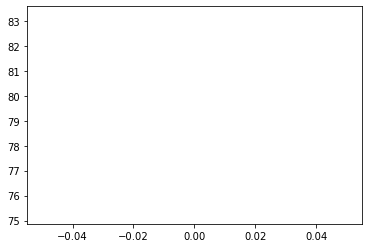

In [137]:
plt.plot(np.max(hess_list, 1))

In [70]:
K_g

5.568433333333332

## For non decreasing lr

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd.functional import hessian
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm 
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import os
import copy
from torch.nn.utils import _stateless

batch_size = 1
num_workers = 1
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
# device

details = {}
details['use_db'] = 'mnist'
details['result_root_dir']='results/t0/'
details['result_path']='try1_t8_w12'
details['g_weight'] = [12]
# details['ratio'] = 15
details['book_keep_freq'] = 20
details['g_times'] = 8
details['g_epochs'] = 10000
details['alpha_0']= 0.003
details['freq_reduce_by'] = 20
details['freq_reduce_after'] = 100

details['training_step_limit'] = 2000000 ## this is to train for max updates per epochs
details['stop_hess_computation'] = 1000000 ## Stop computing hessian after calculated these many times


print(f'selected weight:{details["g_weight"]}')

with open(details['result_root_dir']+'details_'+details['result_path']+'.txt', 'w+') as f:
    for key, val in details.items():
        content = key + ' : '+str(val) + '\n'
        f.write(content)
        
torch.manual_seed(3407)
np.random.seed(3407)
torch.cuda.manual_seed_all(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)
# os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

train_data_all = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data_all = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
# print(f'train data:{train_data}')
# print(f'test data:{test_data}')

def get_random_subset(train_data_all, test_data_all):    
    # train_indices = torch.arange(20000)
    test_indices = torch.arange(256)
    train_indices = torch.randint(60000-1, (2000,))
    # print(f'train indices:{train_indices[:10]}')
    train_data = data_utils.Subset(train_data_all, train_indices)
    test_data = data_utils.Subset(test_data_all, test_indices)
    # print(f'train data:{train_data}')
    # print(f'test data:{test_data}')
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(0)

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=256,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    print(f'train data size:{len(train_loader.dataset)}')
    print(f'test data size:{len(test_loader.dataset)}')
    # X_mat, y_mat = torch.Tensor(len(train_loader.dataset),784), torch.Tensor(len(train_loader.dataset)).long()
    # for i, (data, label) in enumerate(train_loader):
    #     X_mat[i] = data.flatten()
    #     y_mat[i] = label.flatten()
    # print(f'X_mat shape:{X_mat.shape}, y_mat shape:{y_mat.shape}')
    return train_loader, test_loader #, X_mat, y_mat


class Net(nn.Module):

    def __init__(self, input_features, hidden_layers, output_size):
        super(Net, self).__init__()
        self.layers = len(hidden_layers) + 1
        self.total_params_len = 0
        self.fc_layers = nn.ModuleList()
        prev_weight = input_features
        
        for i, weight in enumerate(hidden_layers):
            self.fc_layers.append(nn.Linear(prev_weight, weight))
            self.total_params_len += prev_weight*weight + weight
            prev_weight = weight
        
        self.fc_last = nn.Linear(hidden_layers[-1], output_size)
        self.total_params_len += hidden_layers[-1]*output_size + output_size
        
        ### Others required params
        self.param_list = []

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        # print('x shape in forward',x.shape)
        for fc_layer in self.fc_layers:
            x = F.relu(fc_layer(x))
        x = self.fc_last(x)
        return x
    
    def fit(self, X, Y, X_val, Y_val, epochs, batch_size=1, **kwargs):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters())
        

class Train_nn:
    
    def __init__(self, input_features, hidden_layers, output_size, lr, decay=True):
        self.model = Net(input_features, hidden_layers=hidden_layers, output_size=output_size)
        self.model.to(device)
        self.loss_fn = nn.CrossEntropyLoss()
        if decay:
            lr_lambda = lambda it: 1/(it+1)
        else:
            lr_lambda = lambda it: 1
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda= lr_lambda)
        
    def get_loss(self, X, y, params=None):
        # if params is not None:
        assert False, "Model not initialized with given params"
        op = self.model(X)
        loss = self.loss_fn(pred, y)
        return loss
    
    def get_gradient(self):
        params = (self.model.parameters())
        grad_norm_sq = torch.tensor(0, dtype=float).to(device)
        # print('grad Norm init:', grad_norm_sq)
        for param in self.model.parameters():
            temp = param.grad.data.pow(2).sum()
            # print(f'param grad norm \n\tsum:{temp.data}')#,\n\tshape:{param.shape}')
            grad_norm_sq += temp
            
        return grad_norm_sq.sqrt().cpu()
    
    def get_gradientv2(self, X, y):
        names = list(n for n, _ in self.model.named_parameters())
        def loss_fun_grad(*params):
            out: torch.Tensor = _stateless.functional_call(self.model, {n: p for n, p in zip(names, params)}, X)
            local_loss = self.loss_fn(out, y)
            return local_loss
        grad_mat = torch.autograd.grad(loss_fun_grad, tuple(self.model.parameters()))
        # print(f'len of hess mat:{len(hess_mat)}')
        # print(f'hess_mat[0] shape:{len(hess_mat[0])}')
        # print(f'hess_mat[0][0] shape:{hess_mat[0][0].shape}')
        grad_norm = torch.tensor(0.).to(device)
        for i in range(len(grad_mat)):
            for j in range(len(grad_mat[0])):
                grad_norm+= grad_mat[i][j].pow(2).sum()
        grad_norm = grad_norm.sqrt()
        # print(f'v2 hess norm{hess_norm}')
        return grad_norm.cpu()
    
    def try_operator_norm(self, hess_mat):
        for i in len(hess_mat):
            for j in len(hess_mat[0]):
                torch.unsqueeze(hess_mat[i][i],0)
        hess_tensor_dim = list(hess_mat[0][0].shape)
        hess_tensor_dim += [n*2,n*2]
        hess_mat_np = np.zeros(shape=hess_tensor_dim)
        hess_tensor = torch.tensor(hess_mat_np)
        torch.cat(hess_mat, out=hess_tensor)
        
        hess_mat.reshpe(n*2,n*2)
        hess_norm = torch.linalg.norm(hess_mat, 2)
        assert False, "Not working"
    
    def get_hessian(self, X, y):
        prev_params = copy.deepcopy(list(self.model.parameters()))
        n = self.model.layers
        def local_model(*params):
            # print(f'len of params:{len(params)}')
            # print(f'shape of params[0]:{params[0].shape}')
            # with torch.no_grad():
            #initialize model with given params
            i = 0
            for i, param in enumerate(self.model.parameters()):
                param.data = params[i]
            pred = self.model(X)
            loss = self.loss_fn(pred, y)
            # print(f'loss type:{type(loss)}')
            return loss
        p =list(self.model.parameters())
        hess_mat = hessian(local_model, tuple(p))
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        
        # print(f'Hess mat len:{len(hess_mat)}')
        # print(f'Hess mat[0] len:{len(hess_mat[0])}')
        # print(f'Hess mat[0][0] shape:{hess_mat[0][0].shape}')
        
        hess_norm = hess_norm.sqrt()
        # print(f'hess norm:{hess_norm}')
        
        # Reinitialize the original params to model
        for i, param in enumerate(self.model.parameters()):
                param.data = prev_params[i]
        
        return hess_norm
    
    def get_hessianv2(self, X,y):
        names = list(n for n, _ in self.model.named_parameters())
        def loss_fun_hess(*params):
            out: torch.Tensor = _stateless.functional_call(self.model, {n: p for n, p in zip(names, params)}, X)
            local_loss = self.loss_fn(out, y)
            return local_loss
        hess_mat = hessian(loss_fun_hess, tuple(self.model.parameters()))
        # print(f'len of hess mat:{len(hess_mat)}')
        # print(f'hess_mat[0] shape:{len(hess_mat[0])}')
        # print(f'hess_mat[0][0] shape:{hess_mat[0][0].shape}')
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        hess_norm = hess_norm.sqrt()
        # print(f'v2 hess norm{hess_norm}')
        return hess_norm.cpu()
        
    def fit(self, train_loader, test_loader, epochs, store_grads=False, store_hessian=False, store_gen_err=False, store_weights=False, store_pt_loss=True, store_freq = 20, freq_reduce_by=None, freq_reduce_after=None):
        
        ## For Book keeping results ##
        self.grads_norms = []
        self.grads_normsv2 = []
        self.param_list = []
        self.hess_norms = []
        self.gen_err = []
        self.train_loss = []
        self.val_loss = []
        self.point_loss = []
        ## Initializing values ##
        terminate_training = False
        store_count = 0
        
        for epoch in tqdm(range(epochs), total=epochs, unit="epoch", disable=True):
            if terminate_training == True:
                break
            for batch, (X, y) in tqdm(enumerate(train_loader), total=len(train_loader), unit='batch'):
                if batch>details['training_step_limit']:
                    terminate_training = True
                    break
                
                X, y =X.to(device), y.to(device)
                pred = self.model(X)
                loss = self.loss_fn(pred, y)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                ## Saving point loss
                if store_pt_loss and (batch%store_freq==0):
                    self.point_loss.append(loss.item())
                    
                ## Saving the weights
                if store_weights and (batch%store_freq==0):
                    current_params = tuple(self.model.parameters())
                    self.param_list.append(current_params)
                
                ## computing and saving the gradient
                if store_grads and (batch% store_freq == 0):
                    # store_count += 1
                    # # print(f'\tstore_freq:{store_freq}, batch:{batch}')
                    # if store_count%freq_reduce_after==0:
                    #     store_freq += freq_reduce_by
                    #     # print(f'store freq:{store_freq}, batch:{batch}')
                    grad_norm_per_update = self.get_gradient()
                    print('grad:', grad_norm_per_update)
                    # print('\tgrad norm:', grad_norm_per_update)
                    self.grads_norms.append(grad_norm_per_update)
                    # self.grads_normsv2.append(self.get_gradientv2(X,y))
                ## computing and saving hessian
                if store_hessian and (batch% store_freq==0):
                    #assert False, "Not implemented"
                    self.optimizer.zero_grad()
                    hess_val = self.get_hessianv2(X,y)
                    print('hess:',hess_val)
                    self.hess_norms.append(hess_val)
                    store_count += 1
                    if store_count%freq_reduce_after==0:
                        store_freq += freq_reduce_by
                
                ## computing and storing the generalization error
                if store_gen_err and (batch% store_freq == 0):
                    assert False, "fix reducing freq to get it working and fastX, fasty"
                    train_loss, test_loss, point_loss=0, 0, 0
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(train_loader):
                            # if sub_batch> batch: # only taking the encountered points to calculate train loss
                            #     break
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            train_loss += self.loss_fn(pred_local, y_local).item()
                    train_loss = train_loss/(batch+1)
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(test_loader):
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            test_loss += self.loss_fn(pred_local, y_local).item()
                    test_batch_size = len(test_loader)
                    # print(f"Number of batches in test:{len(test_loader)}")
                    test_loss = test_loss/ len(test_loader)
                    self.train_loss.append(train_loss)
                    self.val_loss.append(test_loss)
                
                if batch % 1000 == 0:
                    loss, current = loss.item(), batch * len(X)
                    correct = 0
                    test_loss = 0
                    with torch.no_grad():
                        for X, y in test_loader:
                            X, y = X.to(device), y.to(device)
                            pred = self.model(X)
                            test_loss += self.loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                    acc = 100*correct/len(test_loader.dataset)
                    print(f"\taccuracy:{acc}")#, at batch:{batch}")
                    print(f"\tloss: {loss:>7f}")
                
                    # print(f'Learning rate:{self.scheduler.get_last_lr()}')
                self.scheduler.step()
            
def exp_get_lp_sm(train_data_all, test_data_all, op_features, weight = 10, times = 8, epochs = 1, root_dir='', path=None, clear_file = True, freq_reduce_by=10, freq_reduce_after=100):
    grad_list        = []
    hess_norm_list   = []
    if path is not None:
        grad_file_path = root_dir+'grad_'+path
        hess_file_path = root_dir+'hess_'+path
        # gen_file_path = root_dir+'gen_'+path
        if clear_file:
            with open(grad_file_path, 'w+') as f:
                f.write('')
            with open(hess_file_path, 'w+') as f:
                f.write('')
    
    train_loader, test_loader = get_random_subset(train_data_all, test_data_all)
    for t in range(times):
        print(f'Time:{t}')
        train_model = Train_nn(784, weight, op_features, lr= details['alpha_0'], decay=False)
        train_model.fit(train_loader, test_loader, epochs=epochs, store_grads=True, store_hessian=True, store_freq=details['book_keep_freq'],  store_gen_err=False, store_pt_loss=False, store_weights=False, freq_reduce_by = freq_reduce_by, freq_reduce_after=freq_reduce_after, )
        
        with open(grad_file_path,'a+') as f:
            f.write(' '.join([str(grad) for grad in train_model.grads_norms]) + '\n')
        with open(hess_file_path,'a+') as f:
            f.write(' '.join([str(hess) for hess in train_model.hess_norms]) + '\n')
        
        hess_norm_list.append(train_model.hess_norms)
        grad_list.append(train_model.grads_norms)
         
    return grad_list, hess_norm_list

grad_list, hess_norm_list = exp_get_lp_sm(train_data_all, test_data_all, op_features=10, 
              weight=details['g_weight'], times=details['g_times'], 
              epochs=details['g_epochs'], root_dir=details['result_root_dir'], 
              path=details['result_path'], freq_reduce_by=details['freq_reduce_by'], 
              freq_reduce_after=details['freq_reduce_after'])


selected weight:[12]
train data size:2000
test data size:256
Time:0


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(4.9090, dtype=torch.float64)
hess: tensor(35.3408)
	accuracy:10.15625
	loss: 2.077993
grad: tensor(3.1533, dtype=torch.float64)
hess: tensor(23.4449)
grad: tensor(2.7884, dtype=torch.float64)
hess: tensor(18.4208)
grad: tensor(3.8249, dtype=torch.float64)
hess: tensor(30.1776)
grad: tensor(2.9495, dtype=torch.float64)
hess: tensor(19.5573)
grad: tensor(3.3696, dtype=torch.float64)
hess: tensor(21.0472)
grad: tensor(3.9576, dtype=torch.float64)
hess: tensor(41.5925)
grad: tensor(2.8509, dtype=torch.float64)
hess: tensor(27.9009)
grad: tensor(3.7645, dtype=torch.float64)
hess: tensor(41.7642)
grad: tensor(2.9160, dtype=torch.float64)
hess: tensor(23.0151)
grad: tensor(5.0757, dtype=torch.float64)
hess: tensor(37.1711)
grad: tensor(4.1145, dtype=torch.float64)
hess: tensor(44.3680)
grad: tensor(3.6553, dtype=torch.float64)
hess: tensor(30.5565)
grad: tensor(3.2693, dtype=torch.float64)
hess: tensor(36.4351)
grad: tensor(3.7443, dtype=torch.float64)
hess: tensor(26.5937)
grad:

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(0.5954, dtype=torch.float64)
hess: tensor(11.3269)
	accuracy:77.34375
	loss: 0.032371
grad: tensor(2.9844, dtype=torch.float64)
hess: tensor(15.7794)
grad: tensor(3.4841, dtype=torch.float64)
hess: tensor(20.8347)
grad: tensor(5.0536, dtype=torch.float64)
hess: tensor(55.4513)
grad: tensor(11.4155, dtype=torch.float64)
hess: tensor(73.1358)
grad: tensor(10.3055, dtype=torch.float64)
hess: tensor(57.4586)
grad: tensor(4.8877, dtype=torch.float64)
hess: tensor(33.9880)
grad: tensor(7.2319, dtype=torch.float64)
hess: tensor(31.9405)
grad: tensor(4.8639, dtype=torch.float64)
hess: tensor(47.8478)
grad: tensor(4.7219, dtype=torch.float64)
hess: tensor(36.4633)
grad: tensor(0.9104, dtype=torch.float64)
hess: tensor(12.7152)
grad: tensor(13.2961, dtype=torch.float64)
hess: tensor(70.3237)
grad: tensor(0.9106, dtype=torch.float64)
hess: tensor(16.1274)
grad: tensor(5.5423, dtype=torch.float64)
hess: tensor(35.4139)
grad: tensor(4.3628, dtype=torch.float64)
hess: tensor(42.1757)
gr

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(0.0570, dtype=torch.float64)
hess: tensor(1.4613)
	accuracy:85.546875
	loss: 0.002388
grad: tensor(1.3613, dtype=torch.float64)
hess: tensor(10.4944)
grad: tensor(1.6814, dtype=torch.float64)
hess: tensor(14.3682)
grad: tensor(4.4507, dtype=torch.float64)
hess: tensor(68.3256)
grad: tensor(12.9868, dtype=torch.float64)
hess: tensor(108.0172)
grad: tensor(14.1767, dtype=torch.float64)
hess: tensor(87.5919)
grad: tensor(4.6074, dtype=torch.float64)
hess: tensor(40.1073)
grad: tensor(9.5155, dtype=torch.float64)
hess: tensor(46.8900)
grad: tensor(2.0006, dtype=torch.float64)
hess: tensor(29.4090)
grad: tensor(4.3347, dtype=torch.float64)
hess: tensor(42.1310)
grad: tensor(0.1327, dtype=torch.float64)
hess: tensor(2.5619)
grad: tensor(17.6388, dtype=torch.float64)
hess: tensor(102.0900)
grad: tensor(0.1955, dtype=torch.float64)
hess: tensor(4.5576)
grad: tensor(4.6430, dtype=torch.float64)
hess: tensor(39.9449)
grad: tensor(1.8025, dtype=torch.float64)
hess: tensor(25.6271)
gr

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(0.0127, dtype=torch.float64)
hess: tensor(0.3502)
	accuracy:88.671875
	loss: 0.000493
grad: tensor(1.3830, dtype=torch.float64)
hess: tensor(24.1108)
grad: tensor(3.8416, dtype=torch.float64)
hess: tensor(69.2523)
grad: tensor(12.8489, dtype=torch.float64)
hess: tensor(45.0307)
grad: tensor(4.1752, dtype=torch.float64)
hess: tensor(42.6748)
grad: tensor(1.2323, dtype=torch.float64)
hess: tensor(24.6928)
grad: tensor(4.9398, dtype=torch.float64)
hess: tensor(51.8502)
grad: tensor(0.8302, dtype=torch.float64)
hess: tensor(8.5015)
grad: tensor(0.0756, dtype=torch.float64)
hess: tensor(1.9648)
grad: tensor(0.0244, dtype=torch.float64)
hess: tensor(0.4963)
grad: tensor(0.2764, dtype=torch.float64)
hess: tensor(5.5910)
grad: tensor(2.3986, dtype=torch.float64)
hess: tensor(31.5668)
grad: tensor(0.2374, dtype=torch.float64)
hess: tensor(3.5709)
grad: tensor(2.2585, dtype=torch.float64)
hess: tensor(28.0621)
grad: tensor(0.2940, dtype=torch.float64)
hess: tensor(5.5198)
grad: tens

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(0.0047, dtype=torch.float64)
hess: tensor(0.1363)
	accuracy:90.234375
	loss: 0.000170
grad: tensor(1.0562, dtype=torch.float64)
hess: tensor(20.1599)
grad: tensor(2.9973, dtype=torch.float64)
hess: tensor(62.0847)
grad: tensor(13.6782, dtype=torch.float64)
hess: tensor(48.3961)
grad: tensor(3.7439, dtype=torch.float64)
hess: tensor(42.7720)
grad: tensor(0.6720, dtype=torch.float64)
hess: tensor(15.3844)
grad: tensor(6.0550, dtype=torch.float64)
hess: tensor(63.6448)
grad: tensor(0.6059, dtype=torch.float64)
hess: tensor(6.7081)
grad: tensor(0.0371, dtype=torch.float64)
hess: tensor(1.0276)
grad: tensor(0.0115, dtype=torch.float64)
hess: tensor(0.2457)
grad: tensor(0.1540, dtype=torch.float64)
hess: tensor(3.4624)
grad: tensor(1.8884, dtype=torch.float64)
hess: tensor(27.8997)
grad: tensor(0.1576, dtype=torch.float64)
hess: tensor(2.5613)
grad: tensor(2.0690, dtype=torch.float64)
hess: tensor(28.6102)
grad: tensor(0.2057, dtype=torch.float64)
hess: tensor(4.1395)
grad: tens

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(0.0021, dtype=torch.float64)
hess: tensor(0.0643)
	accuracy:91.796875
	loss: 0.000071
grad: tensor(0.8559, dtype=torch.float64)
hess: tensor(17.5364)
grad: tensor(2.3424, dtype=torch.float64)
hess: tensor(54.0422)
grad: tensor(14.1355, dtype=torch.float64)
hess: tensor(51.7790)
grad: tensor(3.4297, dtype=torch.float64)
hess: tensor(42.4703)
grad: tensor(0.4164, dtype=torch.float64)
hess: tensor(10.3080)
grad: tensor(7.1198, dtype=torch.float64)
hess: tensor(74.0244)
grad: tensor(0.5041, dtype=torch.float64)
hess: tensor(5.8616)
grad: tensor(0.0220, dtype=torch.float64)
hess: tensor(0.6378)
grad: tensor(0.0065, dtype=torch.float64)
hess: tensor(0.1424)
grad: tensor(0.1114, dtype=torch.float64)
hess: tensor(2.7004)
grad: tensor(1.4579, dtype=torch.float64)
hess: tensor(23.6362)
grad: tensor(0.1151, dtype=torch.float64)
hess: tensor(1.9654)
grad: tensor(2.0380, dtype=torch.float64)
hess: tensor(30.1407)
grad: tensor(0.1544, dtype=torch.float64)
hess: tensor(3.2735)
grad: tens

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(0.0010, dtype=torch.float64)
hess: tensor(0.0325)
	accuracy:92.1875
	loss: 0.000033
grad: tensor(0.4839, dtype=torch.float64)
hess: tensor(6.6719)
grad: tensor(15.7073, dtype=torch.float64)
hess: tensor(152.7978)
grad: tensor(3.0679, dtype=torch.float64)
hess: tensor(40.8380)
grad: tensor(0.4244, dtype=torch.float64)
hess: tensor(9.6433)
grad: tensor(0.0117, dtype=torch.float64)
hess: tensor(0.2871)
grad: tensor(0.0147, dtype=torch.float64)
hess: tensor(0.4416)
grad: tensor(0.2485, dtype=torch.float64)
hess: tensor(5.4644)
grad: tensor(0.1056, dtype=torch.float64)
hess: tensor(2.5048)
grad: tensor(0.0879, dtype=torch.float64)
hess: tensor(1.5603)
grad: tensor(0.3861, dtype=torch.float64)
hess: tensor(4.0006)
grad: tensor(0.1693, dtype=torch.float64)
hess: tensor(4.1047)
grad: tensor(2.9633, dtype=torch.float64)
hess: tensor(46.3602)
	accuracy:87.890625
	loss: 0.011381
grad: tensor(0.1374, dtype=torch.float64)
hess: tensor(2.3988)
grad: tensor(0.0887, dtype=torch.float64)
h

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(0.0006, dtype=torch.float64)
hess: tensor(0.0185)
	accuracy:91.796875
	loss: 0.000018
grad: tensor(0.4476, dtype=torch.float64)
hess: tensor(6.4640)
grad: tensor(14.8466, dtype=torch.float64)
hess: tensor(149.6377)
grad: tensor(2.8414, dtype=torch.float64)
hess: tensor(39.8985)
grad: tensor(0.3709, dtype=torch.float64)
hess: tensor(8.8025)
grad: tensor(0.0091, dtype=torch.float64)
hess: tensor(0.2298)
grad: tensor(0.0109, dtype=torch.float64)
hess: tensor(0.3358)
grad: tensor(0.1644, dtype=torch.float64)
hess: tensor(3.7762)
grad: tensor(0.0808, dtype=torch.float64)
hess: tensor(1.9889)
grad: tensor(0.0680, dtype=torch.float64)
hess: tensor(1.2517)
grad: tensor(0.3410, dtype=torch.float64)
hess: tensor(3.6339)
grad: tensor(0.1374, dtype=torch.float64)
hess: tensor(3.4474)
grad: tensor(2.2993, dtype=torch.float64)
hess: tensor(38.9082)
	accuracy:87.890625
	loss: 0.008607
grad: tensor(0.1049, dtype=torch.float64)
hess: tensor(1.9189)
grad: tensor(0.0746, dtype=torch.float64)

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(0.0003, dtype=torch.float64)
hess: tensor(0.0102)
	accuracy:91.796875
	loss: 0.000009
grad: tensor(0.4419, dtype=torch.float64)
hess: tensor(6.6476)
grad: tensor(14.0377, dtype=torch.float64)
hess: tensor(146.5299)
grad: tensor(2.6656, dtype=torch.float64)
hess: tensor(39.1916)
grad: tensor(0.3182, dtype=torch.float64)
hess: tensor(7.8281)
grad: tensor(0.0073, dtype=torch.float64)
hess: tensor(0.1863)
grad: tensor(0.0083, dtype=torch.float64)
hess: tensor(0.2640)
grad: tensor(0.1019, dtype=torch.float64)
hess: tensor(2.3251)
grad: tensor(0.0678, dtype=torch.float64)
hess: tensor(1.7203)
grad: tensor(0.0560, dtype=torch.float64)
hess: tensor(1.0641)
grad: tensor(0.3108, dtype=torch.float64)
hess: tensor(3.3876)
grad: tensor(0.1113, dtype=torch.float64)
hess: tensor(2.8804)
grad: tensor(1.7773, dtype=torch.float64)
hess: tensor(31.9950)
	accuracy:88.28125
	loss: 0.007013
grad: tensor(0.0869, dtype=torch.float64)
hess: tensor(1.6514)
grad: tensor(0.0658, dtype=torch.float64)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(0.0002, dtype=torch.float64)
hess: tensor(0.0059)
	accuracy:91.796875
	loss: 0.000005
grad: tensor(0.4440, dtype=torch.float64)
hess: tensor(6.9204)
grad: tensor(12.8449, dtype=torch.float64)
hess: tensor(141.7827)
grad: tensor(2.4799, dtype=torch.float64)
hess: tensor(38.1215)
grad: tensor(0.2738, dtype=torch.float64)
hess: tensor(6.9522)
grad: tensor(0.0058, dtype=torch.float64)
hess: tensor(0.1510)
grad: tensor(0.0065, dtype=torch.float64)
hess: tensor(0.2125)
grad: tensor(0.0740, dtype=torch.float64)
hess: tensor(1.7408)
grad: tensor(0.0568, dtype=torch.float64)
hess: tensor(1.4530)
grad: tensor(0.0451, dtype=torch.float64)
hess: tensor(0.8798)
grad: tensor(0.2833, dtype=torch.float64)
hess: tensor(3.1542)
grad: tensor(0.0914, dtype=torch.float64)
hess: tensor(2.4326)
grad: tensor(1.3704, dtype=torch.float64)
hess: tensor(24.5452)
	accuracy:88.28125
	loss: 0.005864
grad: tensor(0.0732, dtype=torch.float64)
hess: tensor(1.4418)
grad: tensor(0.0588, dtype=torch.float64)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(0.0001, dtype=torch.float64)
hess: tensor(0.0036)
	accuracy:91.015625
	loss: 0.000003
grad: tensor(0.4910, dtype=torch.float64)
hess: tensor(6.2593)
grad: tensor(12.1699, dtype=torch.float64)
hess: tensor(132.2207)
grad: tensor(0.0581, dtype=torch.float64)
hess: tensor(1.6791)
grad: tensor(0.0048, dtype=torch.float64)
hess: tensor(0.1293)
grad: tensor(6.9632, dtype=torch.float64)
hess: tensor(104.2412)
grad: tensor(0.0773, dtype=torch.float64)
hess: tensor(2.2879)
grad: tensor(0.4289, dtype=torch.float64)
hess: tensor(10.5822)
grad: tensor(0.2557, dtype=torch.float64)
hess: tensor(2.9074)
grad: tensor(1.0138, dtype=torch.float64)
hess: tensor(15.1523)
grad: tensor(0.0826, dtype=torch.float64)
hess: tensor(1.5037)
	accuracy:88.28125
	loss: 0.004871
grad: tensor(5.9145, dtype=torch.float64)
hess: tensor(58.9840)
grad: tensor(0.5534, dtype=torch.float64)
hess: tensor(13.7032)
grad: tensor(12.4398, dtype=torch.float64)
hess: tensor(84.9129)
grad: tensor(0.6863, dtype=torch.flo

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(6.2293e-05, dtype=torch.float64)
hess: tensor(0.0022)
	accuracy:91.40625
	loss: 0.000002
grad: tensor(0.4578, dtype=torch.float64)
hess: tensor(5.9837)
grad: tensor(11.4830, dtype=torch.float64)
hess: tensor(128.8590)
grad: tensor(0.0420, dtype=torch.float64)
hess: tensor(1.2324)
grad: tensor(0.0040, dtype=torch.float64)
hess: tensor(0.1094)
grad: tensor(6.4777, dtype=torch.float64)
hess: tensor(101.7603)
grad: tensor(0.0603, dtype=torch.float64)
hess: tensor(1.8255)
grad: tensor(0.3959, dtype=torch.float64)
hess: tensor(9.9893)
grad: tensor(0.2333, dtype=torch.float64)
hess: tensor(2.7062)
grad: tensor(0.9815, dtype=torch.float64)
hess: tensor(15.0892)
grad: tensor(0.0725, dtype=torch.float64)
hess: tensor(1.3582)
	accuracy:88.671875
	loss: 0.004159
grad: tensor(6.0410, dtype=torch.float64)
hess: tensor(61.6281)
grad: tensor(0.4990, dtype=torch.float64)
hess: tensor(12.7019)
grad: tensor(12.7268, dtype=torch.float64)
hess: tensor(88.6700)
grad: tensor(0.5407, dtype=torch.

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(3.7940e-05, dtype=torch.float64)
hess: tensor(0.0013)
	accuracy:91.40625
	loss: 0.000001
grad: tensor(0.3778, dtype=torch.float64)
hess: tensor(4.6075)
grad: tensor(10.8265, dtype=torch.float64)
hess: tensor(126.8922)
grad: tensor(0.0295, dtype=torch.float64)
hess: tensor(0.8811)
grad: tensor(0.0033, dtype=torch.float64)
hess: tensor(0.0923)
grad: tensor(6.1786, dtype=torch.float64)
hess: tensor(100.4974)
grad: tensor(0.0633, dtype=torch.float64)
hess: tensor(1.9621)
grad: tensor(0.3502, dtype=torch.float64)
hess: tensor(9.0502)
grad: tensor(0.2187, dtype=torch.float64)
hess: tensor(2.5844)
grad: tensor(0.9699, dtype=torch.float64)
hess: tensor(15.3028)
grad: tensor(0.0651, dtype=torch.float64)
hess: tensor(1.2541)
	accuracy:88.28125
	loss: 0.003618
grad: tensor(6.0345, dtype=torch.float64)
hess: tensor(63.3871)
grad: tensor(0.4544, dtype=torch.float64)
hess: tensor(11.8690)
grad: tensor(12.9597, dtype=torch.float64)
hess: tensor(92.3549)
grad: tensor(0.4366, dtype=torch.f

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(2.3460e-05, dtype=torch.float64)
hess: tensor(0.0009)
	accuracy:91.40625
	loss: 0.000001
grad: tensor(0.3602, dtype=torch.float64)
hess: tensor(4.5016)
grad: tensor(10.2558, dtype=torch.float64)
hess: tensor(124.8490)
grad: tensor(0.0213, dtype=torch.float64)
hess: tensor(0.6459)
grad: tensor(0.0029, dtype=torch.float64)
hess: tensor(0.0805)
grad: tensor(5.5646, dtype=torch.float64)
hess: tensor(95.9778)
grad: tensor(0.0586, dtype=torch.float64)
hess: tensor(1.8528)
grad: tensor(0.3182, dtype=torch.float64)
hess: tensor(8.3968)
grad: tensor(0.2005, dtype=torch.float64)
hess: tensor(2.4093)
grad: tensor(0.9658, dtype=torch.float64)
hess: tensor(15.5895)
grad: tensor(0.0582, dtype=torch.float64)
hess: tensor(1.1500)
	accuracy:88.28125
	loss: 0.003143
grad: tensor(5.9131, dtype=torch.float64)
hess: tensor(64.2652)
grad: tensor(0.4027, dtype=torch.float64)
hess: tensor(10.7618)
grad: tensor(13.1495, dtype=torch.float64)
hess: tensor(95.6153)
grad: tensor(0.3751, dtype=torch.fl

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.6099e-05, dtype=torch.float64)
hess: tensor(0.0006)
	accuracy:91.40625
	loss: 0.000000
grad: tensor(0.3747, dtype=torch.float64)
hess: tensor(5.0761)
grad: tensor(9.4823, dtype=torch.float64)
hess: tensor(121.2702)
grad: tensor(0.0150, dtype=torch.float64)
hess: tensor(0.4598)
grad: tensor(0.0024, dtype=torch.float64)
hess: tensor(0.0699)
grad: tensor(5.3129, dtype=torch.float64)
hess: tensor(94.5986)
grad: tensor(0.0538, dtype=torch.float64)
hess: tensor(1.7354)
grad: tensor(0.2904, dtype=torch.float64)
hess: tensor(7.8193)
grad: tensor(0.1875, dtype=torch.float64)
hess: tensor(2.2956)
grad: tensor(0.9632, dtype=torch.float64)
hess: tensor(15.9161)
grad: tensor(0.0518, dtype=torch.float64)
hess: tensor(1.0488)
	accuracy:88.28125
	loss: 0.002722
grad: tensor(5.8729, dtype=torch.float64)
hess: tensor(65.5306)
grad: tensor(0.3708, dtype=torch.float64)
hess: tensor(10.1465)
grad: tensor(13.4596, dtype=torch.float64)
hess: tensor(99.0226)
grad: tensor(0.2907, dtype=torch.flo

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.2453e-05, dtype=torch.float64)
hess: tensor(0.0005)
	accuracy:91.796875
	loss: 0.000000
grad: tensor(0.1984, dtype=torch.float64)
hess: tensor(7.2624)
grad: tensor(1.5960, dtype=torch.float64)
hess: tensor(30.4332)
grad: tensor(6.0210, dtype=torch.float64)
hess: tensor(87.4867)
grad: tensor(0.0023, dtype=torch.float64)
hess: tensor(0.0836)
grad: tensor(0.0412, dtype=torch.float64)
hess: tensor(1.3561)
grad: tensor(0.0175, dtype=torch.float64)
hess: tensor(0.3931)
grad: tensor(0.0452, dtype=torch.float64)
hess: tensor(1.1978)
grad: tensor(0.6419, dtype=torch.float64)
hess: tensor(13.3573)
	accuracy:88.28125
	loss: 0.002317
grad: tensor(0.0018, dtype=torch.float64)
hess: tensor(0.0593)
grad: tensor(0.3288, dtype=torch.float64)
hess: tensor(9.2051)
grad: tensor(0.0967, dtype=torch.float64)
hess: tensor(3.5704)
grad: tensor(0.9079, dtype=torch.float64)
hess: tensor(20.5602)
grad: tensor(0.0644, dtype=torch.float64)
hess: tensor(2.3398)
grad: tensor(0.6483, dtype=torch.float6

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(9.0501e-06, dtype=torch.float64)
hess: tensor(0.0004)
	accuracy:91.40625
	loss: 0.000000
grad: tensor(0.1459, dtype=torch.float64)
hess: tensor(5.3534)
grad: tensor(1.5229, dtype=torch.float64)
hess: tensor(29.8117)
grad: tensor(5.4781, dtype=torch.float64)
hess: tensor(84.1148)
grad: tensor(0.0022, dtype=torch.float64)
hess: tensor(0.0818)
grad: tensor(0.0371, dtype=torch.float64)
hess: tensor(1.2432)
grad: tensor(0.0148, dtype=torch.float64)
hess: tensor(0.3397)
grad: tensor(0.0415, dtype=torch.float64)
hess: tensor(1.1186)
grad: tensor(0.5395, dtype=torch.float64)
hess: tensor(11.5234)
	accuracy:88.671875
	loss: 0.001990
grad: tensor(0.0014, dtype=torch.float64)
hess: tensor(0.0493)
grad: tensor(0.3062, dtype=torch.float64)
hess: tensor(8.7621)
grad: tensor(0.0854, dtype=torch.float64)
hess: tensor(3.2047)
grad: tensor(0.7988, dtype=torch.float64)
hess: tensor(18.5407)
grad: tensor(0.0421, dtype=torch.float64)
hess: tensor(1.5634)
grad: tensor(0.5928, dtype=torch.float6

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(5.8837e-06, dtype=torch.float64)
hess: tensor(0.0003)
	accuracy:91.796875
	loss: 0.000000
grad: tensor(0.1233, dtype=torch.float64)
hess: tensor(4.7169)
grad: tensor(1.4768, dtype=torch.float64)
hess: tensor(29.5663)
grad: tensor(4.7817, dtype=torch.float64)
hess: tensor(78.5743)
grad: tensor(0.0018, dtype=torch.float64)
hess: tensor(0.0682)
grad: tensor(0.0368, dtype=torch.float64)
hess: tensor(1.2547)
grad: tensor(0.0118, dtype=torch.float64)
hess: tensor(0.2760)
grad: tensor(0.0370, dtype=torch.float64)
hess: tensor(1.0124)
grad: tensor(0.4734, dtype=torch.float64)
hess: tensor(10.2912)
	accuracy:88.28125
	loss: 0.001734
grad: tensor(0.0011, dtype=torch.float64)
hess: tensor(0.0397)
grad: tensor(0.2737, dtype=torch.float64)
hess: tensor(7.9889)
grad: tensor(0.0778, dtype=torch.float64)
hess: tensor(3.0010)
grad: tensor(0.7299, dtype=torch.float64)
hess: tensor(17.2920)
grad: tensor(0.0337, dtype=torch.float64)
hess: tensor(1.2742)
grad: tensor(0.5300, dtype=torch.float6

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(5.3314e-06, dtype=torch.float64)
hess: tensor(0.0002)
	accuracy:91.796875
	loss: 0.000000
grad: tensor(0.0994, dtype=torch.float64)
hess: tensor(3.7890)
grad: tensor(1.3657, dtype=torch.float64)
hess: tensor(28.1425)
grad: tensor(4.4730, dtype=torch.float64)
hess: tensor(76.5511)
grad: tensor(0.0017, dtype=torch.float64)
hess: tensor(0.0641)
grad: tensor(0.0282, dtype=torch.float64)
hess: tensor(0.9772)
grad: tensor(0.0109, dtype=torch.float64)
hess: tensor(0.2598)
grad: tensor(0.0347, dtype=torch.float64)
hess: tensor(0.9660)
grad: tensor(0.3988, dtype=torch.float64)
hess: tensor(8.8837)
	accuracy:88.28125
	loss: 0.001476
grad: tensor(0.0010, dtype=torch.float64)
hess: tensor(0.0352)
grad: tensor(0.2512, dtype=torch.float64)
hess: tensor(6.9588)
grad: tensor(0.0711, dtype=torch.float64)
hess: tensor(2.7463)
grad: tensor(0.6293, dtype=torch.float64)
hess: tensor(15.2743)
grad: tensor(0.0227, dtype=torch.float64)
hess: tensor(0.8744)
grad: tensor(0.4949, dtype=torch.float64

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(4.9676e-06, dtype=torch.float64)
hess: tensor(0.0002)
	accuracy:91.40625
	loss: 0.000000
grad: tensor(0.0856, dtype=torch.float64)
hess: tensor(3.3197)
grad: tensor(1.3240, dtype=torch.float64)
hess: tensor(27.8469)
grad: tensor(3.8496, dtype=torch.float64)
hess: tensor(68.4986)
grad: tensor(0.0014, dtype=torch.float64)
hess: tensor(0.0546)
grad: tensor(0.0268, dtype=torch.float64)
hess: tensor(0.9445)
grad: tensor(0.0087, dtype=torch.float64)
hess: tensor(0.2114)
grad: tensor(0.0323, dtype=torch.float64)
hess: tensor(0.9121)
grad: tensor(0.3476, dtype=torch.float64)
hess: tensor(7.8757)
	accuracy:88.671875
	loss: 0.001300
grad: tensor(0.0008, dtype=torch.float64)
hess: tensor(0.0280)
grad: tensor(0.2359, dtype=torch.float64)
hess: tensor(6.9675)
grad: tensor(0.0661, dtype=torch.float64)
hess: tensor(2.6185)
grad: tensor(0.5791, dtype=torch.float64)
hess: tensor(14.3411)
grad: tensor(0.0180, dtype=torch.float64)
hess: tensor(0.7039)
grad: tensor(0.4437, dtype=torch.float64

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(4.6742e-06, dtype=torch.float64)
hess: tensor(0.0002)
	accuracy:91.015625
	loss: 0.000000
grad: tensor(0.0735, dtype=torch.float64)
hess: tensor(2.8972)
grad: tensor(1.2015, dtype=torch.float64)
hess: tensor(26.0081)
grad: tensor(3.6872, dtype=torch.float64)
hess: tensor(67.5667)
grad: tensor(0.0013, dtype=torch.float64)
hess: tensor(0.0508)
grad: tensor(0.0203, dtype=torch.float64)
hess: tensor(0.7237)
grad: tensor(0.0079, dtype=torch.float64)
hess: tensor(0.1958)
grad: tensor(0.0297, dtype=torch.float64)
hess: tensor(0.8491)
grad: tensor(0.3131, dtype=torch.float64)
hess: tensor(7.2425)
	accuracy:88.28125
	loss: 0.001122
grad: tensor(0.0007, dtype=torch.float64)
hess: tensor(0.0243)
grad: tensor(0.2121, dtype=torch.float64)
hess: tensor(6.3744)
grad: tensor(0.0593, dtype=torch.float64)
hess: tensor(2.3809)
grad: tensor(0.5116, dtype=torch.float64)
hess: tensor(12.8907)
grad: tensor(0.1340, dtype=torch.float64)
hess: tensor(4.8640)
grad: tensor(0.4296, dtype=torch.float64

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(4.5087e-06, dtype=torch.float64)
hess: tensor(0.0002)
	accuracy:91.015625
	loss: 0.000000
grad: tensor(0.0711, dtype=torch.float64)
hess: tensor(1.7666)
grad: tensor(8.5918, dtype=torch.float64)
hess: tensor(84.4208)
grad: tensor(0.3713, dtype=torch.float64)
hess: tensor(5.8301)
grad: tensor(0.0044, dtype=torch.float64)
hess: tensor(0.1311)
grad: tensor(0.1915, dtype=torch.float64)
hess: tensor(5.8307)
grad: tensor(0.0282, dtype=torch.float64)
hess: tensor(0.8161)
grad: tensor(0.0302, dtype=torch.float64)
hess: tensor(1.0191)
	accuracy:88.28125
	loss: 0.000932
grad: tensor(0.0270, dtype=torch.float64)
hess: tensor(0.8078)
grad: tensor(1.6562, dtype=torch.float64)
hess: tensor(43.1041)
grad: tensor(0.0958, dtype=torch.float64)
hess: tensor(2.7267)
grad: tensor(0.1200, dtype=torch.float64)
hess: tensor(4.4183)
grad: tensor(0.4021, dtype=torch.float64)
hess: tensor(10.9837)
grad: tensor(0.0131, dtype=torch.float64)
hess: tensor(0.4644)
grad: tensor(0.1432, dtype=torch.float64

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(4.3802e-06, dtype=torch.float64)
hess: tensor(0.0002)
	accuracy:91.015625
	loss: 0.000000
grad: tensor(0.0669, dtype=torch.float64)
hess: tensor(1.6842)
grad: tensor(8.1681, dtype=torch.float64)
hess: tensor(83.3781)
grad: tensor(0.3643, dtype=torch.float64)
hess: tensor(5.7994)
grad: tensor(0.0037, dtype=torch.float64)
hess: tensor(0.1115)
grad: tensor(0.1860, dtype=torch.float64)
hess: tensor(5.7461)
grad: tensor(0.0263, dtype=torch.float64)
hess: tensor(0.7726)
grad: tensor(0.0259, dtype=torch.float64)
hess: tensor(0.8886)
	accuracy:88.671875
	loss: 0.000815
grad: tensor(0.0256, dtype=torch.float64)
hess: tensor(0.7770)
grad: tensor(1.6150, dtype=torch.float64)
hess: tensor(42.8860)
grad: tensor(0.0839, dtype=torch.float64)
hess: tensor(2.4262)
grad: tensor(0.1137, dtype=torch.float64)
hess: tensor(4.3301)
grad: tensor(0.3677, dtype=torch.float64)
hess: tensor(10.2130)
grad: tensor(0.0123, dtype=torch.float64)
hess: tensor(0.4396)
grad: tensor(0.1377, dtype=torch.float6

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.8538e-06, dtype=torch.float64)
hess: tensor(0.0001)
	accuracy:90.625
	loss: 0.000000
grad: tensor(0.0593, dtype=torch.float64)
hess: tensor(1.5085)
grad: tensor(8.0308, dtype=torch.float64)
hess: tensor(83.6492)
grad: tensor(0.3565, dtype=torch.float64)
hess: tensor(5.7524)
grad: tensor(0.0031, dtype=torch.float64)
hess: tensor(0.0954)
grad: tensor(0.1777, dtype=torch.float64)
hess: tensor(5.5663)
grad: tensor(0.0254, dtype=torch.float64)
hess: tensor(0.7546)
grad: tensor(0.0216, dtype=torch.float64)
hess: tensor(0.7533)
	accuracy:88.671875
	loss: 0.000710
grad: tensor(0.0237, dtype=torch.float64)
hess: tensor(0.7279)
grad: tensor(1.5766, dtype=torch.float64)
hess: tensor(42.7063)
grad: tensor(0.0745, dtype=torch.float64)
hess: tensor(2.1854)
grad: tensor(0.1056, dtype=torch.float64)
hess: tensor(4.0736)
grad: tensor(0.3487, dtype=torch.float64)
hess: tensor(9.8402)
grad: tensor(0.0106, dtype=torch.float64)
hess: tensor(0.3829)
grad: tensor(0.1309, dtype=torch.float64)
h

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.4072e-06, dtype=torch.float64)
hess: tensor(8.4611e-05)
	accuracy:90.625
	loss: 0.000000
grad: tensor(0.0569, dtype=torch.float64)
hess: tensor(1.4662)
grad: tensor(7.8922, dtype=torch.float64)
hess: tensor(83.7503)
grad: tensor(0.3934, dtype=torch.float64)
hess: tensor(6.4052)
grad: tensor(0.0025, dtype=torch.float64)
hess: tensor(0.0775)
grad: tensor(0.1758, dtype=torch.float64)
hess: tensor(5.5773)
grad: tensor(0.0238, dtype=torch.float64)
hess: tensor(0.7176)
grad: tensor(0.0197, dtype=torch.float64)
hess: tensor(0.6971)
	accuracy:88.671875
	loss: 0.000596
grad: tensor(0.0222, dtype=torch.float64)
hess: tensor(0.6888)
grad: tensor(1.5798, dtype=torch.float64)
hess: tensor(43.5024)
grad: tensor(0.0662, dtype=torch.float64)
hess: tensor(1.9728)
grad: tensor(0.0978, dtype=torch.float64)
hess: tensor(3.8236)
grad: tensor(0.3516, dtype=torch.float64)
hess: tensor(10.3903)
grad: tensor(0.0096, dtype=torch.float64)
hess: tensor(0.3499)
grad: tensor(0.1259, dtype=torch.float

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.2325e-06, dtype=torch.float64)
hess: tensor(7.1971e-05)
	accuracy:90.625
	loss: 0.000000
grad: tensor(0.0537, dtype=torch.float64)
hess: tensor(1.4012)
grad: tensor(7.3074, dtype=torch.float64)
hess: tensor(81.0316)
grad: tensor(0.3609, dtype=torch.float64)
hess: tensor(5.9636)
grad: tensor(0.0022, dtype=torch.float64)
hess: tensor(0.0691)
grad: tensor(0.1681, dtype=torch.float64)
hess: tensor(5.4059)
grad: tensor(0.0228, dtype=torch.float64)
hess: tensor(0.6941)
grad: tensor(0.0161, dtype=torch.float64)
hess: tensor(0.5754)
	accuracy:88.671875
	loss: 0.000531
grad: tensor(0.0212, dtype=torch.float64)
hess: tensor(0.6650)
grad: tensor(1.6398, dtype=torch.float64)
hess: tensor(45.6310)
grad: tensor(0.0603, dtype=torch.float64)
hess: tensor(1.8191)
grad: tensor(0.0923, dtype=torch.float64)
hess: tensor(3.6377)
grad: tensor(0.3410, dtype=torch.float64)
hess: tensor(10.2164)
grad: tensor(0.0087, dtype=torch.float64)
hess: tensor(0.3183)
grad: tensor(0.1226, dtype=torch.float

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.0477e-06, dtype=torch.float64)
hess: tensor(5.7547e-05)
	accuracy:90.625
	loss: 0.000000
grad: tensor(0.0509, dtype=torch.float64)
hess: tensor(1.3434)
grad: tensor(7.3010, dtype=torch.float64)
hess: tensor(81.9415)
grad: tensor(0.3866, dtype=torch.float64)
hess: tensor(6.4574)
grad: tensor(0.0017, dtype=torch.float64)
hess: tensor(0.0564)
grad: tensor(0.1598, dtype=torch.float64)
hess: tensor(5.2057)
grad: tensor(0.0222, dtype=torch.float64)
hess: tensor(0.6851)
grad: tensor(0.0136, dtype=torch.float64)
hess: tensor(0.4938)
	accuracy:88.671875
	loss: 0.000456
grad: tensor(0.0198, dtype=torch.float64)
hess: tensor(0.6298)
grad: tensor(1.6131, dtype=torch.float64)
hess: tensor(45.7815)
grad: tensor(0.0551, dtype=torch.float64)
hess: tensor(1.6859)
grad: tensor(0.0862, dtype=torch.float64)
hess: tensor(3.4420)
grad: tensor(0.3303, dtype=torch.float64)
hess: tensor(10.0305)
grad: tensor(0.0079, dtype=torch.float64)
hess: tensor(0.2900)
grad: tensor(0.1203, dtype=torch.float

  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(9.4423e-07, dtype=torch.float64)
hess: tensor(5.2876e-05)
	accuracy:89.84375
	loss: 0.000000
grad: tensor(0.0472, dtype=torch.float64)
hess: tensor(1.2597)
grad: tensor(6.7906, dtype=torch.float64)
hess: tensor(79.0881)
grad: tensor(0.3640, dtype=torch.float64)
hess: tensor(6.1514)
grad: tensor(0.0015, dtype=torch.float64)
hess: tensor(0.0497)
grad: tensor(0.1550, dtype=torch.float64)
hess: tensor(5.1121)
grad: tensor(0.0599, dtype=torch.float64)
hess: tensor(0.8811)
grad: tensor(0.1319, dtype=torch.float64)
hess: tensor(3.4571)
	accuracy:89.453125
	loss: 0.000398
grad: tensor(0.0192, dtype=torch.float64)
hess: tensor(0.6154)
grad: tensor(0.0069, dtype=torch.float64)
hess: tensor(0.2395)
grad: tensor(0.3218, dtype=torch.float64)
hess: tensor(9.0809)
grad: tensor(0.7629, dtype=torch.float64)
hess: tensor(18.5771)
grad: tensor(1.6221, dtype=torch.float64)
hess: tensor(36.5300)
grad: tensor(4.7710, dtype=torch.float64)
hess: tensor(80.6860)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(8.1143e-07, dtype=torch.float64)
hess: tensor(4.5481e-05)
	accuracy:89.84375
	loss: 0.000000
grad: tensor(1.2433, dtype=torch.float64)
hess: tensor(42.0706)
grad: tensor(0.0176, dtype=torch.float64)
hess: tensor(0.6127)
grad: tensor(0.0006, dtype=torch.float64)
hess: tensor(0.0264)
grad: tensor(0.0212, dtype=torch.float64)
hess: tensor(0.7470)
grad: tensor(0.0551, dtype=torch.float64)
hess: tensor(0.8212)
grad: tensor(0.1113, dtype=torch.float64)
hess: tensor(2.9617)
	accuracy:89.0625
	loss: 0.000345
grad: tensor(0.0178, dtype=torch.float64)
hess: tensor(0.5782)
grad: tensor(0.0062, dtype=torch.float64)
hess: tensor(0.2177)
grad: tensor(0.3073, dtype=torch.float64)
hess: tensor(8.7701)
grad: tensor(0.7446, dtype=torch.float64)
hess: tensor(18.3738)
grad: tensor(1.6387, dtype=torch.float64)
hess: tensor(37.1372)
grad: tensor(4.5910, dtype=torch.float64)
hess: tensor(79.3843)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(7.0519e-07, dtype=torch.float64)
hess: tensor(3.9777e-05)
	accuracy:89.84375
	loss: 0.000000
grad: tensor(1.1481, dtype=torch.float64)
hess: tensor(39.7071)
grad: tensor(0.0166, dtype=torch.float64)
hess: tensor(0.5805)
grad: tensor(0.0006, dtype=torch.float64)
hess: tensor(0.0237)
grad: tensor(0.0209, dtype=torch.float64)
hess: tensor(0.7457)
grad: tensor(0.0503, dtype=torch.float64)
hess: tensor(0.7557)
grad: tensor(0.1031, dtype=torch.float64)
hess: tensor(2.7787)
	accuracy:89.453125
	loss: 0.000317
grad: tensor(0.0167, dtype=torch.float64)
hess: tensor(0.5483)
grad: tensor(0.0055, dtype=torch.float64)
hess: tensor(0.1930)
grad: tensor(0.2696, dtype=torch.float64)
hess: tensor(7.8159)
grad: tensor(0.6915, dtype=torch.float64)
hess: tensor(17.3580)
grad: tensor(1.6502, dtype=torch.float64)
hess: tensor(37.8012)
grad: tensor(4.3902, dtype=torch.float64)
hess: tensor(77.8052)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(6.0998e-07, dtype=torch.float64)
hess: tensor(3.4732e-05)
	accuracy:89.84375
	loss: 0.000000
grad: tensor(1.0356, dtype=torch.float64)
hess: tensor(36.6882)
grad: tensor(0.0141, dtype=torch.float64)
hess: tensor(0.5026)
grad: tensor(0.0005, dtype=torch.float64)
hess: tensor(0.0225)
grad: tensor(0.0203, dtype=torch.float64)
hess: tensor(0.7322)
grad: tensor(0.0468, dtype=torch.float64)
hess: tensor(0.7115)
grad: tensor(0.0908, dtype=torch.float64)
hess: tensor(2.4812)
	accuracy:89.453125
	loss: 0.000267
grad: tensor(0.0158, dtype=torch.float64)
hess: tensor(0.5222)
grad: tensor(0.0050, dtype=torch.float64)
hess: tensor(0.1790)
grad: tensor(0.2502, dtype=torch.float64)
hess: tensor(7.3551)
grad: tensor(0.6555, dtype=torch.float64)
hess: tensor(16.7001)
grad: tensor(1.6730, dtype=torch.float64)
hess: tensor(38.5905)
grad: tensor(4.1501, dtype=torch.float64)
hess: tensor(75.5694)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(5.3054e-07, dtype=torch.float64)
hess: tensor(3.0459e-05)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(0.9733, dtype=torch.float64)
hess: tensor(35.0846)
grad: tensor(0.0130, dtype=torch.float64)
hess: tensor(0.4688)
grad: tensor(0.0005, dtype=torch.float64)
hess: tensor(0.0205)
grad: tensor(0.0205, dtype=torch.float64)
hess: tensor(0.7462)
grad: tensor(0.0421, dtype=torch.float64)
hess: tensor(0.6453)
grad: tensor(0.0775, dtype=torch.float64)
hess: tensor(2.1455)
	accuracy:89.453125
	loss: 0.000246
grad: tensor(0.0154, dtype=torch.float64)
hess: tensor(0.5122)
grad: tensor(0.0046, dtype=torch.float64)
hess: tensor(0.1655)
grad: tensor(0.2324, dtype=torch.float64)
hess: tensor(6.9106)
grad: tensor(0.6276, dtype=torch.float64)
hess: tensor(16.1976)
grad: tensor(1.6898, dtype=torch.float64)
hess: tensor(39.2846)
grad: tensor(3.9362, dtype=torch.float64)
hess: tensor(73.4879)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(4.6575e-07, dtype=torch.float64)
hess: tensor(2.7041e-05)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(0.9024, dtype=torch.float64)
hess: tensor(33.1288)
grad: tensor(0.0118, dtype=torch.float64)
hess: tensor(0.4321)
grad: tensor(0.0005, dtype=torch.float64)
hess: tensor(0.0207)
grad: tensor(0.0198, dtype=torch.float64)
hess: tensor(0.7280)
grad: tensor(0.0398, dtype=torch.float64)
hess: tensor(0.6155)
grad: tensor(0.0712, dtype=torch.float64)
hess: tensor(1.9943)
	accuracy:89.453125
	loss: 0.000213
grad: tensor(0.0144, dtype=torch.float64)
hess: tensor(0.4828)
grad: tensor(0.0043, dtype=torch.float64)
hess: tensor(0.1542)
grad: tensor(0.2118, dtype=torch.float64)
hess: tensor(6.3848)
grad: tensor(0.6305, dtype=torch.float64)
hess: tensor(16.9306)
grad: tensor(1.6689, dtype=torch.float64)
hess: tensor(39.2217)
grad: tensor(3.7281, dtype=torch.float64)
hess: tensor(71.3691)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(4.1553e-07, dtype=torch.float64)
hess: tensor(2.4537e-05)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(0.8879, dtype=torch.float64)
hess: tensor(32.9404)
grad: tensor(0.0110, dtype=torch.float64)
hess: tensor(0.4050)
grad: tensor(0.0004, dtype=torch.float64)
hess: tensor(0.0179)
grad: tensor(0.0195, dtype=torch.float64)
hess: tensor(0.7263)
grad: tensor(0.0356, dtype=torch.float64)
hess: tensor(0.5572)
grad: tensor(0.0611, dtype=torch.float64)
hess: tensor(1.7286)
	accuracy:89.453125
	loss: 0.000196
grad: tensor(0.0138, dtype=torch.float64)
hess: tensor(0.4684)
grad: tensor(0.0039, dtype=torch.float64)
hess: tensor(0.1406)
grad: tensor(0.2060, dtype=torch.float64)
hess: tensor(6.2766)
grad: tensor(0.5932, dtype=torch.float64)
hess: tensor(16.1457)
grad: tensor(1.6567, dtype=torch.float64)
hess: tensor(39.3377)
grad: tensor(3.5732, dtype=torch.float64)
hess: tensor(69.8194)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(3.7522e-07, dtype=torch.float64)
hess: tensor(2.2630e-05)
	accuracy:89.84375
	loss: 0.000000
grad: tensor(0.8079, dtype=torch.float64)
hess: tensor(30.5665)
grad: tensor(0.0096, dtype=torch.float64)
hess: tensor(0.3594)
grad: tensor(0.0004, dtype=torch.float64)
hess: tensor(0.0171)
grad: tensor(0.0189, dtype=torch.float64)
hess: tensor(0.7115)
grad: tensor(0.0339, dtype=torch.float64)
hess: tensor(0.5345)
grad: tensor(0.0547, dtype=torch.float64)
hess: tensor(1.5618)
	accuracy:89.0625
	loss: 0.000171
grad: tensor(0.0130, dtype=torch.float64)
hess: tensor(0.4426)
grad: tensor(0.0035, dtype=torch.float64)
hess: tensor(0.1278)
grad: tensor(0.1879, dtype=torch.float64)
hess: tensor(5.7940)
grad: tensor(0.5633, dtype=torch.float64)
hess: tensor(14.6394)
grad: tensor(1.6372, dtype=torch.float64)
hess: tensor(39.2423)
grad: tensor(3.3710, dtype=torch.float64)
hess: tensor(67.4768)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(3.2470e-07, dtype=torch.float64)
hess: tensor(1.9012e-05)
	accuracy:89.84375
	loss: 0.000000
grad: tensor(1.6098, dtype=torch.float64)
hess: tensor(31.5776)
grad: tensor(1.6893, dtype=torch.float64)
hess: tensor(44.3888)
grad: tensor(7.5542e-05, dtype=torch.float64)
hess: tensor(0.0032)
grad: tensor(0.0008, dtype=torch.float64)
hess: tensor(0.0234)
grad: tensor(0.6717, dtype=torch.float64)
hess: tensor(15.6997)
	accuracy:88.671875
	loss: 0.000150
grad: tensor(8.1000e-05, dtype=torch.float64)
hess: tensor(0.0032)
grad: tensor(1.3479, dtype=torch.float64)
hess: tensor(43.9940)
grad: tensor(0.1823, dtype=torch.float64)
hess: tensor(5.6395)
grad: tensor(1.1668, dtype=torch.float64)
hess: tensor(31.7425)
grad: tensor(0.0016, dtype=torch.float64)
hess: tensor(0.0632)
grad: tensor(0.0421, dtype=torch.float64)
hess: tensor(1.1489)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(2.7396e-07, dtype=torch.float64)
hess: tensor(1.7196e-05)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(1.5429, dtype=torch.float64)
hess: tensor(30.6720)
grad: tensor(1.5927, dtype=torch.float64)
hess: tensor(42.6472)
grad: tensor(7.1055e-05, dtype=torch.float64)
hess: tensor(0.0030)
grad: tensor(0.0007, dtype=torch.float64)
hess: tensor(0.0204)
grad: tensor(0.6407, dtype=torch.float64)
hess: tensor(15.1311)
	accuracy:89.0625
	loss: 0.000144
grad: tensor(7.6912e-05, dtype=torch.float64)
hess: tensor(0.0030)
grad: tensor(1.3177, dtype=torch.float64)
hess: tensor(43.5505)
grad: tensor(0.1608, dtype=torch.float64)
hess: tensor(5.0495)
grad: tensor(1.0899, dtype=torch.float64)
hess: tensor(29.3798)
grad: tensor(0.0015, dtype=torch.float64)
hess: tensor(0.0594)
grad: tensor(0.0391, dtype=torch.float64)
hess: tensor(1.0761)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(2.4827e-07, dtype=torch.float64)
hess: tensor(1.5706e-05)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(1.4618, dtype=torch.float64)
hess: tensor(29.4861)
grad: tensor(1.5530, dtype=torch.float64)
hess: tensor(42.1062)
grad: tensor(6.7268e-05, dtype=torch.float64)
hess: tensor(0.0029)
grad: tensor(0.0006, dtype=torch.float64)
hess: tensor(0.0188)
grad: tensor(0.6403, dtype=torch.float64)
hess: tensor(15.2814)
	accuracy:88.671875
	loss: 0.000125
grad: tensor(6.8922e-05, dtype=torch.float64)
hess: tensor(0.0028)
grad: tensor(1.2165, dtype=torch.float64)
hess: tensor(41.0682)
grad: tensor(0.1456, dtype=torch.float64)
hess: tensor(4.6176)
grad: tensor(1.0367, dtype=torch.float64)
hess: tensor(28.3779)
grad: tensor(0.0014, dtype=torch.float64)
hess: tensor(0.0530)
grad: tensor(0.0375, dtype=torch.float64)
hess: tensor(1.0403)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(2.1481e-07, dtype=torch.float64)
hess: tensor(1.2670e-05)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(1.3908, dtype=torch.float64)
hess: tensor(28.4698)
grad: tensor(1.5393, dtype=torch.float64)
hess: tensor(42.1203)
grad: tensor(6.2613e-05, dtype=torch.float64)
hess: tensor(0.0027)
grad: tensor(0.0006, dtype=torch.float64)
hess: tensor(0.0168)
grad: tensor(0.6072, dtype=torch.float64)
hess: tensor(14.6434)
	accuracy:89.0625
	loss: 0.000113
grad: tensor(6.1259e-05, dtype=torch.float64)
hess: tensor(0.0025)
grad: tensor(1.1793, dtype=torch.float64)
hess: tensor(40.3146)
grad: tensor(0.1391, dtype=torch.float64)
hess: tensor(4.4455)
grad: tensor(0.9971, dtype=torch.float64)
hess: tensor(27.6522)
grad: tensor(0.0012, dtype=torch.float64)
hess: tensor(0.0486)
grad: tensor(0.0360, dtype=torch.float64)
hess: tensor(1.0064)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.8301e-07, dtype=torch.float64)
hess: tensor(1.1062e-05)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(1.3444, dtype=torch.float64)
hess: tensor(27.8266)
grad: tensor(1.4595, dtype=torch.float64)
hess: tensor(40.5925)
grad: tensor(6.0641e-05, dtype=torch.float64)
hess: tensor(0.0026)
grad: tensor(0.0005, dtype=torch.float64)
hess: tensor(0.0151)
grad: tensor(0.5991, dtype=torch.float64)
hess: tensor(14.5802)
	accuracy:89.453125
	loss: 0.000105
grad: tensor(5.6760e-05, dtype=torch.float64)
hess: tensor(0.0023)
grad: tensor(1.1321, dtype=torch.float64)
hess: tensor(39.2272)
grad: tensor(0.1272, dtype=torch.float64)
hess: tensor(4.1025)
grad: tensor(0.9330, dtype=torch.float64)
hess: tensor(26.2766)
grad: tensor(0.0012, dtype=torch.float64)
hess: tensor(0.0461)
grad: tensor(0.0339, dtype=torch.float64)
hess: tensor(0.9562)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.6653e-07, dtype=torch.float64)
hess: tensor(1.0209e-05)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(1.2869, dtype=torch.float64)
hess: tensor(26.9530)
grad: tensor(1.4510, dtype=torch.float64)
hess: tensor(40.6855)
grad: tensor(5.7436e-05, dtype=torch.float64)
hess: tensor(0.0025)
grad: tensor(0.0005, dtype=torch.float64)
hess: tensor(0.0137)
grad: tensor(0.5907, dtype=torch.float64)
hess: tensor(14.4959)
	accuracy:89.453125
	loss: 0.000093
grad: tensor(5.2179e-05, dtype=torch.float64)
hess: tensor(0.0021)
grad: tensor(1.0880, dtype=torch.float64)
hess: tensor(38.1940)
grad: tensor(0.1172, dtype=torch.float64)
hess: tensor(3.8174)
grad: tensor(0.8901, dtype=torch.float64)
hess: tensor(25.3937)
grad: tensor(0.0011, dtype=torch.float64)
hess: tensor(0.0421)
grad: tensor(0.0323, dtype=torch.float64)
hess: tensor(0.9178)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.4355e-07, dtype=torch.float64)
hess: tensor(8.6041e-06)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(1.2462, dtype=torch.float64)
hess: tensor(26.3926)
grad: tensor(1.3605, dtype=torch.float64)
hess: tensor(38.8179)
grad: tensor(5.6197e-05, dtype=torch.float64)
hess: tensor(0.0024)
grad: tensor(0.0004, dtype=torch.float64)
hess: tensor(0.0126)
grad: tensor(0.5602, dtype=torch.float64)
hess: tensor(13.8608)
	accuracy:89.453125
	loss: 0.000089
grad: tensor(4.5574e-05, dtype=torch.float64)
hess: tensor(0.0020)
grad: tensor(1.0563, dtype=torch.float64)
hess: tensor(37.4933)
grad: tensor(0.1083, dtype=torch.float64)
hess: tensor(3.5541)
grad: tensor(0.8494, dtype=torch.float64)
hess: tensor(24.5300)
grad: tensor(0.0010, dtype=torch.float64)
hess: tensor(0.0405)
grad: tensor(0.0305, dtype=torch.float64)
hess: tensor(0.8727)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.3119e-07, dtype=torch.float64)
hess: tensor(7.9178e-06)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(1.1792, dtype=torch.float64)
hess: tensor(25.2836)
grad: tensor(1.4030, dtype=torch.float64)
hess: tensor(40.0954)
grad: tensor(5.2181e-05, dtype=torch.float64)
hess: tensor(0.0023)
grad: tensor(0.0004, dtype=torch.float64)
hess: tensor(0.0113)
grad: tensor(0.5588, dtype=torch.float64)
hess: tensor(13.9280)
	accuracy:89.453125
	loss: 0.000079
grad: tensor(4.4216e-05, dtype=torch.float64)
hess: tensor(0.0019)
grad: tensor(1.0025, dtype=torch.float64)
hess: tensor(36.0789)
grad: tensor(0.1114, dtype=torch.float64)
hess: tensor(3.6613)
grad: tensor(0.8115, dtype=torch.float64)
hess: tensor(23.7082)
grad: tensor(0.0009, dtype=torch.float64)
hess: tensor(0.0370)
grad: tensor(0.0300, dtype=torch.float64)
hess: tensor(0.8628)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.1189e-07, dtype=torch.float64)
hess: tensor(6.5530e-06)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(1.1414, dtype=torch.float64)
hess: tensor(24.7154)
grad: tensor(1.3313, dtype=torch.float64)
hess: tensor(38.6145)
grad: tensor(4.7181e-05, dtype=torch.float64)
hess: tensor(0.0021)
grad: tensor(0.0003, dtype=torch.float64)
hess: tensor(0.0102)
grad: tensor(0.0205, dtype=torch.float64)
hess: tensor(0.3404)
grad: tensor(0.0021, dtype=torch.float64)
hess: tensor(0.0634)
	accuracy:89.84375
	loss: 0.000073
grad: tensor(0.0947, dtype=torch.float64)
hess: tensor(3.6044)
grad: tensor(0.0171, dtype=torch.float64)
hess: tensor(0.6110)
grad: tensor(0.3954, dtype=torch.float64)
hess: tensor(11.5540)
grad: tensor(0.0009, dtype=torch.float64)
hess: tensor(0.0344)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(9.8407e-08, dtype=torch.float64)
hess: tensor(5.8539e-06)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(2.2448, dtype=torch.float64)
hess: tensor(61.7234)
grad: tensor(3.8110e-05, dtype=torch.float64)
hess: tensor(0.0015)
grad: tensor(0.0009, dtype=torch.float64)
hess: tensor(0.0373)
grad: tensor(0.0195, dtype=torch.float64)
hess: tensor(0.3255)
grad: tensor(0.0019, dtype=torch.float64)
hess: tensor(0.0582)
	accuracy:89.84375
	loss: 0.000066
grad: tensor(0.0894, dtype=torch.float64)
hess: tensor(3.4309)
grad: tensor(0.0156, dtype=torch.float64)
hess: tensor(0.5610)
grad: tensor(0.3785, dtype=torch.float64)
hess: tensor(11.1565)
grad: tensor(0.0008, dtype=torch.float64)
hess: tensor(0.0325)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(8.9034e-08, dtype=torch.float64)
hess: tensor(5.3711e-06)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(2.1767, dtype=torch.float64)
hess: tensor(60.5765)
grad: tensor(3.3747e-05, dtype=torch.float64)
hess: tensor(0.0013)
grad: tensor(0.0008, dtype=torch.float64)
hess: tensor(0.0364)
grad: tensor(0.0180, dtype=torch.float64)
hess: tensor(0.3040)
grad: tensor(0.0019, dtype=torch.float64)
hess: tensor(0.0571)
	accuracy:89.84375
	loss: 0.000064
grad: tensor(0.0863, dtype=torch.float64)
hess: tensor(3.3264)
grad: tensor(0.0153, dtype=torch.float64)
hess: tensor(0.5540)
grad: tensor(0.3706, dtype=torch.float64)
hess: tensor(11.0002)
grad: tensor(0.0007, dtype=torch.float64)
hess: tensor(0.0302)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(7.9316e-08, dtype=torch.float64)
hess: tensor(4.8710e-06)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(2.2293, dtype=torch.float64)
hess: tensor(62.0023)
grad: tensor(2.8838e-05, dtype=torch.float64)
hess: tensor(0.0012)
grad: tensor(0.0007, dtype=torch.float64)
hess: tensor(0.0317)
grad: tensor(0.0177, dtype=torch.float64)
hess: tensor(0.2997)
grad: tensor(0.0017, dtype=torch.float64)
hess: tensor(0.0520)
	accuracy:89.84375
	loss: 0.000057
grad: tensor(0.0850, dtype=torch.float64)
hess: tensor(3.3009)
grad: tensor(0.0145, dtype=torch.float64)
hess: tensor(0.5279)
grad: tensor(0.3516, dtype=torch.float64)
hess: tensor(10.5235)
grad: tensor(0.0007, dtype=torch.float64)
hess: tensor(0.0281)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(7.0509e-08, dtype=torch.float64)
hess: tensor(4.4072e-06)
	accuracy:88.671875
	loss: 0.000000
grad: tensor(2.1379, dtype=torch.float64)
hess: tensor(60.3447)
grad: tensor(2.5601e-05, dtype=torch.float64)
hess: tensor(0.0010)
grad: tensor(0.0007, dtype=torch.float64)
hess: tensor(0.0320)
grad: tensor(0.0164, dtype=torch.float64)
hess: tensor(0.2809)
grad: tensor(0.0016, dtype=torch.float64)
hess: tensor(0.0505)
	accuracy:89.84375
	loss: 0.000055
grad: tensor(0.0802, dtype=torch.float64)
hess: tensor(3.1298)
grad: tensor(0.0139, dtype=torch.float64)
hess: tensor(0.5083)
grad: tensor(0.3429, dtype=torch.float64)
hess: tensor(10.3322)
grad: tensor(0.0007, dtype=torch.float64)
hess: tensor(0.0271)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(6.2452e-08, dtype=torch.float64)
hess: tensor(3.9878e-06)
	accuracy:88.28125
	loss: 0.000000
grad: tensor(2.1432, dtype=torch.float64)
hess: tensor(60.7683)
grad: tensor(2.4677e-05, dtype=torch.float64)
hess: tensor(0.0010)
grad: tensor(0.0007, dtype=torch.float64)
hess: tensor(0.0303)
grad: tensor(0.0157, dtype=torch.float64)
hess: tensor(0.2706)
grad: tensor(0.0015, dtype=torch.float64)
hess: tensor(0.0461)
	accuracy:89.84375
	loss: 0.000050
grad: tensor(0.0782, dtype=torch.float64)
hess: tensor(3.0777)
grad: tensor(0.0135, dtype=torch.float64)
hess: tensor(0.4964)
grad: tensor(0.3307, dtype=torch.float64)
hess: tensor(10.0333)
grad: tensor(0.0006, dtype=torch.float64)
hess: tensor(0.0254)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(5.6514e-08, dtype=torch.float64)
hess: tensor(3.6611e-06)
	accuracy:88.671875
	loss: 0.000000
grad: tensor(1.9687, dtype=torch.float64)
hess: tensor(57.1319)
grad: tensor(2.0352e-05, dtype=torch.float64)
hess: tensor(0.0008)
grad: tensor(0.0007, dtype=torch.float64)
hess: tensor(0.0292)
grad: tensor(0.0151, dtype=torch.float64)
hess: tensor(0.2611)
grad: tensor(0.0014, dtype=torch.float64)
hess: tensor(0.0447)
	accuracy:89.453125
	loss: 0.000048
grad: tensor(0.0783, dtype=torch.float64)
hess: tensor(3.0939)
grad: tensor(0.0126, dtype=torch.float64)
hess: tensor(0.4675)
grad: tensor(0.3227, dtype=torch.float64)
hess: tensor(9.8544)
grad: tensor(0.0006, dtype=torch.float64)
hess: tensor(0.0241)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(5.0127e-08, dtype=torch.float64)
hess: tensor(2.8854e-06)
	accuracy:88.671875
	loss: 0.000000
grad: tensor(1.9771, dtype=torch.float64)
hess: tensor(57.6282)
grad: tensor(1.9096e-05, dtype=torch.float64)
hess: tensor(0.0008)
grad: tensor(0.0006, dtype=torch.float64)
hess: tensor(0.0275)
grad: tensor(0.0144, dtype=torch.float64)
hess: tensor(0.2501)
grad: tensor(0.0013, dtype=torch.float64)
hess: tensor(0.0415)
	accuracy:89.453125
	loss: 0.000044
grad: tensor(0.0716, dtype=torch.float64)
hess: tensor(2.8441)
grad: tensor(0.0118, dtype=torch.float64)
hess: tensor(0.4397)
grad: tensor(0.3106, dtype=torch.float64)
hess: tensor(9.5482)
grad: tensor(0.0005, dtype=torch.float64)
hess: tensor(0.0223)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(4.5094e-08, dtype=torch.float64)
hess: tensor(2.6048e-06)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(2.0029, dtype=torch.float64)
hess: tensor(58.4790)
grad: tensor(1.8466e-05, dtype=torch.float64)
hess: tensor(0.0007)
grad: tensor(0.0006, dtype=torch.float64)
hess: tensor(0.0266)
grad: tensor(0.0135, dtype=torch.float64)
hess: tensor(0.2357)
grad: tensor(0.0013, dtype=torch.float64)
hess: tensor(0.0400)
	accuracy:89.453125
	loss: 0.000042
grad: tensor(0.0669, dtype=torch.float64)
hess: tensor(2.6716)
grad: tensor(0.0111, dtype=torch.float64)
hess: tensor(0.4136)
grad: tensor(0.2965, dtype=torch.float64)
hess: tensor(9.1766)
grad: tensor(0.0005, dtype=torch.float64)
hess: tensor(0.0223)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(3.8974e-08, dtype=torch.float64)
hess: tensor(2.2584e-06)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(1.9791, dtype=torch.float64)
hess: tensor(58.1846)
grad: tensor(1.4906e-05, dtype=torch.float64)
hess: tensor(0.0006)
grad: tensor(0.0006, dtype=torch.float64)
hess: tensor(0.0260)
grad: tensor(0.0128, dtype=torch.float64)
hess: tensor(0.2249)
grad: tensor(0.0012, dtype=torch.float64)
hess: tensor(0.0373)
	accuracy:89.453125
	loss: 0.000039
grad: tensor(0.0677, dtype=torch.float64)
hess: tensor(2.7215)
grad: tensor(0.0104, dtype=torch.float64)
hess: tensor(0.3910)
grad: tensor(0.2934, dtype=torch.float64)
hess: tensor(9.1291)
grad: tensor(0.0005, dtype=torch.float64)
hess: tensor(0.0204)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(3.5894e-08, dtype=torch.float64)
hess: tensor(2.0871e-06)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(1.9878, dtype=torch.float64)
hess: tensor(58.6555)
grad: tensor(1.4342e-05, dtype=torch.float64)
hess: tensor(0.0006)
grad: tensor(0.0005, dtype=torch.float64)
hess: tensor(0.0238)
grad: tensor(0.0073, dtype=torch.float64)
hess: tensor(0.2557)
grad: tensor(0.0001, dtype=torch.float64)
hess: tensor(0.0056)
	accuracy:89.453125
	loss: 0.000036
grad: tensor(2.3005, dtype=torch.float64)
hess: tensor(46.5263)
grad: tensor(0.0040, dtype=torch.float64)
hess: tensor(0.2085)
grad: tensor(0.0139, dtype=torch.float64)
hess: tensor(0.6803)
grad: tensor(1.2370, dtype=torch.float64)
hess: tensor(35.3252)
grad: tensor(0.0200, dtype=torch.float64)
hess: tensor(0.6093)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(3.1421e-08, dtype=torch.float64)
hess: tensor(1.8327e-06)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.0002, dtype=torch.float64)
hess: tensor(0.0062)
grad: tensor(4.7906, dtype=torch.float64)
hess: tensor(106.0392)
grad: tensor(0.0069, dtype=torch.float64)
hess: tensor(0.2440)
grad: tensor(0.0001, dtype=torch.float64)
hess: tensor(0.0052)
	accuracy:89.453125
	loss: 0.000034
grad: tensor(2.2894, dtype=torch.float64)
hess: tensor(46.8753)
grad: tensor(0.0039, dtype=torch.float64)
hess: tensor(0.2007)
grad: tensor(0.0132, dtype=torch.float64)
hess: tensor(0.6452)
grad: tensor(1.2309, dtype=torch.float64)
hess: tensor(35.3153)
grad: tensor(0.0193, dtype=torch.float64)
hess: tensor(0.5926)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(2.8297e-08, dtype=torch.float64)
hess: tensor(1.6551e-06)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.0002, dtype=torch.float64)
hess: tensor(0.0057)
grad: tensor(4.7318, dtype=torch.float64)
hess: tensor(105.6490)
grad: tensor(0.0064, dtype=torch.float64)
hess: tensor(0.2274)
grad: tensor(0.0001, dtype=torch.float64)
hess: tensor(0.0047)
	accuracy:89.453125
	loss: 0.000032
grad: tensor(2.2681, dtype=torch.float64)
hess: tensor(46.9829)
grad: tensor(0.0037, dtype=torch.float64)
hess: tensor(0.1923)
grad: tensor(0.0125, dtype=torch.float64)
hess: tensor(0.6153)
grad: tensor(1.1977, dtype=torch.float64)
hess: tensor(34.6399)
grad: tensor(0.0190, dtype=torch.float64)
hess: tensor(0.5833)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(2.4783e-08, dtype=torch.float64)
hess: tensor(1.4543e-06)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.0001, dtype=torch.float64)
hess: tensor(0.0052)
grad: tensor(4.6598, dtype=torch.float64)
hess: tensor(105.0817)
grad: tensor(0.0061, dtype=torch.float64)
hess: tensor(0.2169)
grad: tensor(9.8339e-05, dtype=torch.float64)
hess: tensor(0.0044)
	accuracy:89.0625
	loss: 0.000030
grad: tensor(2.1174, dtype=torch.float64)
hess: tensor(46.7357)
grad: tensor(0.0034, dtype=torch.float64)
hess: tensor(0.1769)
grad: tensor(0.0117, dtype=torch.float64)
hess: tensor(0.5789)
grad: tensor(1.1576, dtype=torch.float64)
hess: tensor(33.7579)
grad: tensor(0.0183, dtype=torch.float64)
hess: tensor(0.5654)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(2.2448e-08, dtype=torch.float64)
hess: tensor(1.3210e-06)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.0001, dtype=torch.float64)
hess: tensor(0.0047)
grad: tensor(4.7387, dtype=torch.float64)
hess: tensor(106.1014)
grad: tensor(0.0058, dtype=torch.float64)
hess: tensor(0.2089)
grad: tensor(8.8051e-05, dtype=torch.float64)
hess: tensor(0.0040)
	accuracy:89.0625
	loss: 0.000028
grad: tensor(2.1929, dtype=torch.float64)
hess: tensor(46.0995)
grad: tensor(0.0030, dtype=torch.float64)
hess: tensor(0.1576)
grad: tensor(0.0111, dtype=torch.float64)
hess: tensor(0.5533)
grad: tensor(1.1392, dtype=torch.float64)
hess: tensor(33.4185)
grad: tensor(0.0178, dtype=torch.float64)
hess: tensor(0.5512)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(2.0140e-08, dtype=torch.float64)
hess: tensor(1.1882e-06)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.0001, dtype=torch.float64)
hess: tensor(0.0044)
grad: tensor(4.4220, dtype=torch.float64)
hess: tensor(102.8636)
grad: tensor(0.0057, dtype=torch.float64)
hess: tensor(0.2037)
grad: tensor(8.4035e-05, dtype=torch.float64)
hess: tensor(0.0038)
	accuracy:89.0625
	loss: 0.000027
grad: tensor(2.0333, dtype=torch.float64)
hess: tensor(45.6058)
grad: tensor(0.0030, dtype=torch.float64)
hess: tensor(0.1583)
grad: tensor(0.0102, dtype=torch.float64)
hess: tensor(0.5101)
grad: tensor(1.1132, dtype=torch.float64)
hess: tensor(32.8811)
grad: tensor(0.0171, dtype=torch.float64)
hess: tensor(0.5340)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.8201e-08, dtype=torch.float64)
hess: tensor(1.0767e-06)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.0001, dtype=torch.float64)
hess: tensor(0.0040)
grad: tensor(4.2351, dtype=torch.float64)
hess: tensor(100.8134)
grad: tensor(0.0052, dtype=torch.float64)
hess: tensor(0.1895)
grad: tensor(7.6595e-05, dtype=torch.float64)
hess: tensor(0.0034)
	accuracy:89.0625
	loss: 0.000025
grad: tensor(2.0195, dtype=torch.float64)
hess: tensor(45.5280)
grad: tensor(0.0030, dtype=torch.float64)
hess: tensor(0.1564)
grad: tensor(0.0100, dtype=torch.float64)
hess: tensor(0.4994)
grad: tensor(1.0970, dtype=torch.float64)
hess: tensor(32.5761)
grad: tensor(0.0167, dtype=torch.float64)
hess: tensor(0.5233)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.5955e-08, dtype=torch.float64)
hess: tensor(9.4656e-07)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(9.7400e-05, dtype=torch.float64)
hess: tensor(0.0037)
grad: tensor(4.2387, dtype=torch.float64)
hess: tensor(101.0181)
grad: tensor(0.0047, dtype=torch.float64)
hess: tensor(0.1711)
grad: tensor(6.4821e-05, dtype=torch.float64)
hess: tensor(0.0030)
	accuracy:89.0625
	loss: 0.000024
grad: tensor(2.1300, dtype=torch.float64)
hess: tensor(45.1171)
grad: tensor(0.0028, dtype=torch.float64)
hess: tensor(0.1476)
grad: tensor(0.0092, dtype=torch.float64)
hess: tensor(0.4635)
grad: tensor(1.0721, dtype=torch.float64)
hess: tensor(32.0531)
grad: tensor(0.0163, dtype=torch.float64)
hess: tensor(0.5120)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.4283e-08, dtype=torch.float64)
hess: tensor(8.4947e-07)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(9.1347e-05, dtype=torch.float64)
hess: tensor(0.0035)
grad: tensor(4.2067, dtype=torch.float64)
hess: tensor(100.8916)
grad: tensor(0.0047, dtype=torch.float64)
hess: tensor(0.1726)
grad: tensor(6.4142e-05, dtype=torch.float64)
hess: tensor(0.0030)
	accuracy:89.453125
	loss: 0.000022
grad: tensor(2.0780, dtype=torch.float64)
hess: tensor(44.7843)
grad: tensor(0.0026, dtype=torch.float64)
hess: tensor(0.1382)
grad: tensor(0.0087, dtype=torch.float64)
hess: tensor(0.4358)
grad: tensor(1.0483, dtype=torch.float64)
hess: tensor(31.5264)
grad: tensor(0.0159, dtype=torch.float64)
hess: tensor(0.5008)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.2812e-08, dtype=torch.float64)
hess: tensor(7.6384e-07)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(8.3577e-05, dtype=torch.float64)
hess: tensor(0.0032)
grad: tensor(4.2355, dtype=torch.float64)
hess: tensor(101.4089)
grad: tensor(0.0045, dtype=torch.float64)
hess: tensor(0.1642)
grad: tensor(5.7639e-05, dtype=torch.float64)
hess: tensor(0.0026)
	accuracy:89.0625
	loss: 0.000021
grad: tensor(1.9109, dtype=torch.float64)
hess: tensor(44.0179)
grad: tensor(0.0024, dtype=torch.float64)
hess: tensor(0.1282)
grad: tensor(0.0085, dtype=torch.float64)
hess: tensor(0.4285)
grad: tensor(1.0249, dtype=torch.float64)
hess: tensor(31.0169)
grad: tensor(0.0155, dtype=torch.float64)
hess: tensor(0.4885)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.1900e-08, dtype=torch.float64)
hess: tensor(7.1128e-07)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(7.8793e-05, dtype=torch.float64)
hess: tensor(0.0030)
grad: tensor(3.9399, dtype=torch.float64)
hess: tensor(97.8527)
grad: tensor(0.0001, dtype=torch.float64)
hess: tensor(0.0053)
grad: tensor(0.0001, dtype=torch.float64)
hess: tensor(0.0034)
grad: tensor(0.0097, dtype=torch.float64)
hess: tensor(0.3217)
	accuracy:89.0625
	loss: 0.000020
grad: tensor(0.0417, dtype=torch.float64)
hess: tensor(1.7565)
grad: tensor(0.0313, dtype=torch.float64)
hess: tensor(1.1388)
grad: tensor(0.1593, dtype=torch.float64)
hess: tensor(6.4819)
grad: tensor(1.0748, dtype=torch.float64)
hess: tensor(30.7160)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.0449e-08, dtype=torch.float64)
hess: tensor(6.2605e-07)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(0.2147, dtype=torch.float64)
hess: tensor(7.4870)
grad: tensor(0.0001, dtype=torch.float64)
hess: tensor(0.0051)
grad: tensor(9.9650e-05, dtype=torch.float64)
hess: tensor(0.0033)
grad: tensor(0.0095, dtype=torch.float64)
hess: tensor(0.3158)
	accuracy:89.0625
	loss: 0.000019
grad: tensor(0.0408, dtype=torch.float64)
hess: tensor(1.7265)
grad: tensor(0.0288, dtype=torch.float64)
hess: tensor(1.0533)
grad: tensor(0.1540, dtype=torch.float64)
hess: tensor(6.2932)
grad: tensor(1.0547, dtype=torch.float64)
hess: tensor(30.3030)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(9.7031e-09, dtype=torch.float64)
hess: tensor(5.8266e-07)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(0.2092, dtype=torch.float64)
hess: tensor(7.3248)
grad: tensor(0.0001, dtype=torch.float64)
hess: tensor(0.0050)
grad: tensor(9.3275e-05, dtype=torch.float64)
hess: tensor(0.0031)
grad: tensor(0.0091, dtype=torch.float64)
hess: tensor(0.3046)
	accuracy:89.84375
	loss: 0.000017
grad: tensor(0.0398, dtype=torch.float64)
hess: tensor(1.6930)
grad: tensor(0.0272, dtype=torch.float64)
hess: tensor(0.9965)
grad: tensor(0.1516, dtype=torch.float64)
hess: tensor(6.2263)
grad: tensor(1.0211, dtype=torch.float64)
hess: tensor(29.5380)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(8.6422e-09, dtype=torch.float64)
hess: tensor(5.2010e-07)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(0.2075, dtype=torch.float64)
hess: tensor(7.2967)
grad: tensor(9.8984e-05, dtype=torch.float64)
hess: tensor(0.0048)
grad: tensor(9.0498e-05, dtype=torch.float64)
hess: tensor(0.0030)
grad: tensor(0.0085, dtype=torch.float64)
hess: tensor(0.2855)
	accuracy:89.453125
	loss: 0.000016
grad: tensor(0.0388, dtype=torch.float64)
hess: tensor(1.6550)
grad: tensor(0.0258, dtype=torch.float64)
hess: tensor(0.9508)
grad: tensor(0.1468, dtype=torch.float64)
hess: tensor(6.0420)
grad: tensor(0.9960, dtype=torch.float64)
hess: tensor(28.9761)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(7.9129e-09, dtype=torch.float64)
hess: tensor(4.7735e-07)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(0.2024, dtype=torch.float64)
hess: tensor(7.1468)
grad: tensor(9.8003e-05, dtype=torch.float64)
hess: tensor(0.0048)
grad: tensor(8.9582e-05, dtype=torch.float64)
hess: tensor(0.0030)
grad: tensor(0.0082, dtype=torch.float64)
hess: tensor(0.2770)
	accuracy:89.453125
	loss: 0.000016
grad: tensor(0.0360, dtype=torch.float64)
hess: tensor(1.5419)
grad: tensor(0.0257, dtype=torch.float64)
hess: tensor(0.9479)
grad: tensor(0.1458, dtype=torch.float64)
hess: tensor(6.0362)
grad: tensor(0.9808, dtype=torch.float64)
hess: tensor(28.6659)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(7.1988e-09, dtype=torch.float64)
hess: tensor(4.3519e-07)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(0.1970, dtype=torch.float64)
hess: tensor(6.9833)
grad: tensor(9.4856e-05, dtype=torch.float64)
hess: tensor(0.0046)
grad: tensor(8.4263e-05, dtype=torch.float64)
hess: tensor(0.0028)
grad: tensor(0.0081, dtype=torch.float64)
hess: tensor(0.2737)
	accuracy:89.84375
	loss: 0.000015
grad: tensor(0.0355, dtype=torch.float64)
hess: tensor(1.5263)
grad: tensor(0.0236, dtype=torch.float64)
hess: tensor(0.8740)
grad: tensor(0.1411, dtype=torch.float64)
hess: tensor(5.8565)
grad: tensor(0.9627, dtype=torch.float64)
hess: tensor(28.2712)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(6.5152e-09, dtype=torch.float64)
hess: tensor(3.9466e-07)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(0.1934, dtype=torch.float64)
hess: tensor(6.8779)
grad: tensor(9.3678e-05, dtype=torch.float64)
hess: tensor(0.0045)
grad: tensor(7.8809e-05, dtype=torch.float64)
hess: tensor(0.0027)
grad: tensor(0.0077, dtype=torch.float64)
hess: tensor(0.2595)
	accuracy:89.84375
	loss: 0.000014
grad: tensor(0.0352, dtype=torch.float64)
hess: tensor(1.5148)
grad: tensor(0.0221, dtype=torch.float64)
hess: tensor(0.8216)
grad: tensor(0.1372, dtype=torch.float64)
hess: tensor(5.7144)
grad: tensor(0.9431, dtype=torch.float64)
hess: tensor(27.8293)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(5.9629e-09, dtype=torch.float64)
hess: tensor(3.6194e-07)
	accuracy:89.453125
	loss: 0.000000
grad: tensor(0.1902, dtype=torch.float64)
hess: tensor(6.7909)
grad: tensor(8.7239e-05, dtype=torch.float64)
hess: tensor(0.0043)
grad: tensor(7.6308e-05, dtype=torch.float64)
hess: tensor(0.0026)
grad: tensor(0.0073, dtype=torch.float64)
hess: tensor(0.2472)
	accuracy:89.453125
	loss: 0.000013
grad: tensor(0.0332, dtype=torch.float64)
hess: tensor(1.4363)
grad: tensor(0.0216, dtype=torch.float64)
hess: tensor(0.8074)
grad: tensor(0.1341, dtype=torch.float64)
hess: tensor(5.6026)
grad: tensor(0.9165, dtype=torch.float64)
hess: tensor(27.1978)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(5.4259e-09, dtype=torch.float64)
hess: tensor(3.3000e-07)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1875, dtype=torch.float64)
hess: tensor(6.7172)
grad: tensor(8.7306e-05, dtype=torch.float64)
hess: tensor(0.0043)
grad: tensor(7.2228e-05, dtype=torch.float64)
hess: tensor(0.0025)
grad: tensor(0.0071, dtype=torch.float64)
hess: tensor(0.2396)
	accuracy:89.84375
	loss: 0.000013
grad: tensor(0.0329, dtype=torch.float64)
hess: tensor(1.4270)
grad: tensor(0.0211, dtype=torch.float64)
hess: tensor(0.7852)
grad: tensor(0.1331, dtype=torch.float64)
hess: tensor(5.5853)
grad: tensor(0.8997, dtype=torch.float64)
hess: tensor(26.8074)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(5.0651e-09, dtype=torch.float64)
hess: tensor(3.0869e-07)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1855, dtype=torch.float64)
hess: tensor(6.6719)
grad: tensor(8.6564e-05, dtype=torch.float64)
hess: tensor(0.0042)
grad: tensor(7.1734e-05, dtype=torch.float64)
hess: tensor(0.0025)
grad: tensor(0.0070, dtype=torch.float64)
hess: tensor(0.2368)
	accuracy:89.84375
	loss: 0.000012
grad: tensor(0.0321, dtype=torch.float64)
hess: tensor(1.3944)
grad: tensor(0.0196, dtype=torch.float64)
hess: tensor(0.7345)
grad: tensor(0.1274, dtype=torch.float64)
hess: tensor(5.3628)
grad: tensor(0.8827, dtype=torch.float64)
hess: tensor(26.4251)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(4.5939e-09, dtype=torch.float64)
hess: tensor(2.8052e-07)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1801, dtype=torch.float64)
hess: tensor(6.4965)
grad: tensor(8.3385e-05, dtype=torch.float64)
hess: tensor(0.0041)
grad: tensor(7.1174e-05, dtype=torch.float64)
hess: tensor(0.0024)
grad: tensor(0.0065, dtype=torch.float64)
hess: tensor(0.2211)
	accuracy:89.84375
	loss: 0.000011
grad: tensor(0.0305, dtype=torch.float64)
hess: tensor(1.3301)
grad: tensor(0.0192, dtype=torch.float64)
hess: tensor(0.7217)
grad: tensor(0.1255, dtype=torch.float64)
hess: tensor(5.3029)
grad: tensor(0.8681, dtype=torch.float64)
hess: tensor(26.1064)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(4.1702e-09, dtype=torch.float64)
hess: tensor(2.5514e-07)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1772, dtype=torch.float64)
hess: tensor(6.4107)
grad: tensor(8.3259e-05, dtype=torch.float64)
hess: tensor(0.0041)
grad: tensor(0.2289, dtype=torch.float64)
hess: tensor(6.8390)
grad: tensor(0.4320, dtype=torch.float64)
hess: tensor(14.5381)
	accuracy:89.84375
	loss: 0.000011
grad: tensor(0.0005, dtype=torch.float64)
hess: tensor(0.0190)
grad: tensor(3.1891, dtype=torch.float64)
hess: tensor(69.4228)
grad: tensor(5.5398e-06, dtype=torch.float64)
hess: tensor(0.0003)
grad: tensor(0.0015, dtype=torch.float64)
hess: tensor(0.0695)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(3.8370e-09, dtype=torch.float64)
hess: tensor(2.3515e-07)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1767, dtype=torch.float64)
hess: tensor(6.9142)
grad: tensor(0.2323, dtype=torch.float64)
hess: tensor(6.9579)
grad: tensor(0.4351, dtype=torch.float64)
hess: tensor(14.6796)
	accuracy:89.84375
	loss: 0.000010
grad: tensor(0.0005, dtype=torch.float64)
hess: tensor(0.0184)
grad: tensor(3.1476, dtype=torch.float64)
hess: tensor(68.9398)
grad: tensor(5.5134e-06, dtype=torch.float64)
hess: tensor(0.0003)
grad: tensor(0.0015, dtype=torch.float64)
hess: tensor(0.0680)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(3.5434e-09, dtype=torch.float64)
hess: tensor(2.1756e-07)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1663, dtype=torch.float64)
hess: tensor(6.5349)
grad: tensor(0.2299, dtype=torch.float64)
hess: tensor(6.9062)
grad: tensor(0.4259, dtype=torch.float64)
hess: tensor(14.4272)
	accuracy:90.234375
	loss: 0.000010
grad: tensor(0.0005, dtype=torch.float64)
hess: tensor(0.0181)
grad: tensor(3.1300, dtype=torch.float64)
hess: tensor(68.8122)
grad: tensor(5.3651e-06, dtype=torch.float64)
hess: tensor(0.0002)
grad: tensor(0.0014, dtype=torch.float64)
hess: tensor(0.0661)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(3.2608e-09, dtype=torch.float64)
hess: tensor(2.0059e-07)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1623, dtype=torch.float64)
hess: tensor(6.3950)
grad: tensor(0.2247, dtype=torch.float64)
hess: tensor(6.7630)
grad: tensor(0.4028, dtype=torch.float64)
hess: tensor(13.7173)
	accuracy:90.234375
	loss: 0.000009
grad: tensor(0.0005, dtype=torch.float64)
hess: tensor(0.0175)
grad: tensor(2.9905, dtype=torch.float64)
hess: tensor(66.7894)
grad: tensor(5.2914e-06, dtype=torch.float64)
hess: tensor(0.0002)
grad: tensor(0.0014, dtype=torch.float64)
hess: tensor(0.0652)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(2.9797e-09, dtype=torch.float64)
hess: tensor(1.8362e-07)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1513, dtype=torch.float64)
hess: tensor(5.9862)
grad: tensor(0.2246, dtype=torch.float64)
hess: tensor(6.7780)
grad: tensor(0.4063, dtype=torch.float64)
hess: tensor(13.8692)
	accuracy:90.234375
	loss: 0.000009
grad: tensor(0.0005, dtype=torch.float64)
hess: tensor(0.0170)
grad: tensor(2.9460, dtype=torch.float64)
hess: tensor(66.2247)
grad: tensor(2.3485e-06, dtype=torch.float64)
hess: tensor(0.0002)
grad: tensor(0.0013, dtype=torch.float64)
hess: tensor(0.0627)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(2.7581e-09, dtype=torch.float64)
hess: tensor(1.7026e-07)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1467, dtype=torch.float64)
hess: tensor(5.8216)
grad: tensor(0.2206, dtype=torch.float64)
hess: tensor(6.6753)
grad: tensor(0.3962, dtype=torch.float64)
hess: tensor(13.5717)
	accuracy:90.234375
	loss: 0.000008
grad: tensor(0.0004, dtype=torch.float64)
hess: tensor(0.0167)
grad: tensor(2.9329, dtype=torch.float64)
hess: tensor(66.1414)
grad: tensor(2.2231e-06, dtype=torch.float64)
hess: tensor(0.0001)
grad: tensor(0.0013, dtype=torch.float64)
hess: tensor(0.0613)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(2.5089e-09, dtype=torch.float64)
hess: tensor(1.5514e-07)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1396, dtype=torch.float64)
hess: tensor(5.5601)
grad: tensor(0.2210, dtype=torch.float64)
hess: tensor(6.7019)
grad: tensor(0.3886, dtype=torch.float64)
hess: tensor(13.3570)
	accuracy:90.234375
	loss: 0.000008
grad: tensor(0.0004, dtype=torch.float64)
hess: tensor(0.0162)
grad: tensor(2.8822, dtype=torch.float64)
hess: tensor(65.4607)
grad: tensor(2.0088e-06, dtype=torch.float64)
hess: tensor(0.0001)
grad: tensor(0.0013, dtype=torch.float64)
hess: tensor(0.0601)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(2.3454e-09, dtype=torch.float64)
hess: tensor(1.4526e-07)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1366, dtype=torch.float64)
hess: tensor(5.4534)
grad: tensor(0.2164, dtype=torch.float64)
hess: tensor(6.5761)
grad: tensor(0.3877, dtype=torch.float64)
hess: tensor(13.3659)
	accuracy:90.234375
	loss: 0.000008
grad: tensor(0.0004, dtype=torch.float64)
hess: tensor(0.0158)
grad: tensor(2.7955, dtype=torch.float64)
hess: tensor(64.1666)
grad: tensor(1.9104e-06, dtype=torch.float64)
hess: tensor(0.0001)
grad: tensor(0.0013, dtype=torch.float64)
hess: tensor(0.0590)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(2.1736e-09, dtype=torch.float64)
hess: tensor(1.3483e-07)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1284, dtype=torch.float64)
hess: tensor(5.1430)
grad: tensor(0.2191, dtype=torch.float64)
hess: tensor(6.6766)
grad: tensor(0.3806, dtype=torch.float64)
hess: tensor(13.1639)
	accuracy:90.234375
	loss: 0.000007
grad: tensor(0.0004, dtype=torch.float64)
hess: tensor(0.0156)
grad: tensor(2.7823, dtype=torch.float64)
hess: tensor(64.0646)
grad: tensor(1.7950e-06, dtype=torch.float64)
hess: tensor(0.0001)
grad: tensor(0.0012, dtype=torch.float64)
hess: tensor(0.0570)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.9789e-09, dtype=torch.float64)
hess: tensor(1.2297e-07)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1239, dtype=torch.float64)
hess: tensor(4.9805)
grad: tensor(0.2115, dtype=torch.float64)
hess: tensor(6.4588)
grad: tensor(0.3749, dtype=torch.float64)
hess: tensor(13.0024)
	accuracy:90.234375
	loss: 0.000007
grad: tensor(0.0004, dtype=torch.float64)
hess: tensor(0.0149)
grad: tensor(2.7438, dtype=torch.float64)
hess: tensor(63.5459)
grad: tensor(1.6841e-06, dtype=torch.float64)
hess: tensor(0.0001)
grad: tensor(0.0012, dtype=torch.float64)
hess: tensor(0.0557)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.8513e-09, dtype=torch.float64)
hess: tensor(1.1522e-07)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1181, dtype=torch.float64)
hess: tensor(4.7609)
grad: tensor(0.2145, dtype=torch.float64)
hess: tensor(6.5608)
grad: tensor(0.3583, dtype=torch.float64)
hess: tensor(12.4825)
	accuracy:90.234375
	loss: 0.000007
grad: tensor(0.0004, dtype=torch.float64)
hess: tensor(0.0147)
grad: tensor(2.6650, dtype=torch.float64)
hess: tensor(62.3239)
grad: tensor(1.5741e-06, dtype=torch.float64)
hess: tensor(0.0001)
grad: tensor(0.0011, dtype=torch.float64)
hess: tensor(0.0542)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.6924e-09, dtype=torch.float64)
hess: tensor(1.0551e-07)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1146, dtype=torch.float64)
hess: tensor(4.6330)
grad: tensor(0.2122, dtype=torch.float64)
hess: tensor(6.5093)
grad: tensor(0.3502, dtype=torch.float64)
hess: tensor(12.2422)
	accuracy:90.234375
	loss: 0.000006
grad: tensor(0.0004, dtype=torch.float64)
hess: tensor(0.0146)
grad: tensor(2.5990, dtype=torch.float64)
hess: tensor(61.3047)
grad: tensor(1.4877e-06, dtype=torch.float64)
hess: tensor(0.0001)
grad: tensor(0.0011, dtype=torch.float64)
hess: tensor(0.0532)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.5657e-09, dtype=torch.float64)
hess: tensor(9.7752e-08)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(0.1098, dtype=torch.float64)
hess: tensor(4.4507)
grad: tensor(0.2098, dtype=torch.float64)
hess: tensor(6.4495)
grad: tensor(0.3543, dtype=torch.float64)
hess: tensor(12.4090)
	accuracy:90.234375
	loss: 0.000006
grad: tensor(0.0004, dtype=torch.float64)
hess: tensor(0.0140)
grad: tensor(2.5839, dtype=torch.float64)
hess: tensor(61.1463)
grad: tensor(0.0014, dtype=torch.float64)
hess: tensor(0.0573)
grad: tensor(0.0958, dtype=torch.float64)
hess: tensor(4.2128)
grad: tensor(0.0139, dtype=torch.float64)
hess: tensor(0.6114)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.4574e-09, dtype=torch.float64)
hess: tensor(9.1127e-08)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(1.4005, dtype=torch.float64)
hess: tensor(30.7156)
grad: tensor(9.1628e-07, dtype=torch.float64)
hess: tensor(5.2649e-05)
grad: tensor(0.0019, dtype=torch.float64)
hess: tensor(0.0781)
	accuracy:90.234375
	loss: 0.000006
grad: tensor(0.0042, dtype=torch.float64)
hess: tensor(0.1734)
grad: tensor(0.0013, dtype=torch.float64)
hess: tensor(0.0544)
grad: tensor(0.0934, dtype=torch.float64)
hess: tensor(4.1147)
grad: tensor(0.0134, dtype=torch.float64)
hess: tensor(0.5887)
hess: tensor(0.0745)
	accuracy:89.84375
	loss: 0.000005
grad: tensor(0.0042, dtype=torch.float64)
hess: tensor(0.1721)
grad: tensor(0.0012, dtype=torch.float64)
hess: tensor(0.0488)
grad: tensor(0.0903, dtype=torch.float64)
hess: tensor(3.9996)
grad: tensor(0.0127, dtype=torch.float64)
hess: tensor(0.5626)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.1614e-09, dtype=torch.float64)
hess: tensor(7.2937e-08)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(1.3309, dtype=torch.float64)
hess: tensor(29.5283)
grad: tensor(7.7951e-07, dtype=torch.float64)
hess: tensor(4.4892e-05)
grad: tensor(0.0018, dtype=torch.float64)
hess: tensor(0.0727)
	accuracy:89.84375
	loss: 0.000005
grad: tensor(0.0041, dtype=torch.float64)
hess: tensor(0.1679)
grad: tensor(0.0011, dtype=torch.float64)
hess: tensor(0.0465)
grad: tensor(0.0886, dtype=torch.float64)
hess: tensor(3.9297)
grad: tensor(0.0126, dtype=torch.float64)
hess: tensor(0.5593)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.0600e-09, dtype=torch.float64)
hess: tensor(6.6662e-08)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(1.3005, dtype=torch.float64)
hess: tensor(28.9822)
grad: tensor(7.3507e-07, dtype=torch.float64)
hess: tensor(4.2463e-05)
grad: tensor(0.0018, dtype=torch.float64)
hess: tensor(0.0726)
	accuracy:89.84375
	loss: 0.000005
grad: tensor(0.0041, dtype=torch.float64)
hess: tensor(0.1692)
grad: tensor(0.0011, dtype=torch.float64)
hess: tensor(0.0443)
grad: tensor(0.0880, dtype=torch.float64)
hess: tensor(3.9192)
grad: tensor(0.0121, dtype=torch.float64)
hess: tensor(0.5358)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(1.0024e-09, dtype=torch.float64)
hess: tensor(6.3124e-08)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(1.2868, dtype=torch.float64)
hess: tensor(28.7659)
grad: tensor(6.7718e-07, dtype=torch.float64)
hess: tensor(3.9510e-05)
grad: tensor(0.0017, dtype=torch.float64)
hess: tensor(0.0693)
	accuracy:89.84375
	loss: 0.000005
grad: tensor(0.0040, dtype=torch.float64)
hess: tensor(0.1644)
grad: tensor(0.0010, dtype=torch.float64)
hess: tensor(0.0422)
grad: tensor(0.0865, dtype=torch.float64)
hess: tensor(3.8596)
grad: tensor(0.0116, dtype=torch.float64)
hess: tensor(0.5176)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(9.2529e-10, dtype=torch.float64)
hess: tensor(5.8351e-08)
	accuracy:89.0625
	loss: 0.000000
grad: tensor(1.2635, dtype=torch.float64)
hess: tensor(28.3506)
grad: tensor(6.5364e-07, dtype=torch.float64)
hess: tensor(3.8217e-05)
grad: tensor(0.0016, dtype=torch.float64)
hess: tensor(0.0685)
	accuracy:89.84375
	loss: 0.000005
grad: tensor(0.0040, dtype=torch.float64)
hess: tensor(0.1653)
grad: tensor(0.0010, dtype=torch.float64)
hess: tensor(0.0401)
grad: tensor(0.0844, dtype=torch.float64)
hess: tensor(3.7727)
grad: tensor(0.0115, dtype=torch.float64)
hess: tensor(0.5112)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(8.5826e-10, dtype=torch.float64)
hess: tensor(5.4199e-08)
	accuracy:88.671875
	loss: 0.000000
grad: tensor(1.2300, dtype=torch.float64)
hess: tensor(27.7278)
grad: tensor(6.0712e-07, dtype=torch.float64)
hess: tensor(3.5452e-05)
grad: tensor(0.0016, dtype=torch.float64)
hess: tensor(0.0671)
	accuracy:89.84375
	loss: 0.000004
grad: tensor(0.0039, dtype=torch.float64)
hess: tensor(0.1631)
grad: tensor(0.0009, dtype=torch.float64)
hess: tensor(0.0386)
grad: tensor(0.0837, dtype=torch.float64)
hess: tensor(3.7504)
grad: tensor(0.0113, dtype=torch.float64)
hess: tensor(0.5016)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(8.0799e-10, dtype=torch.float64)
hess: tensor(5.1090e-08)
	accuracy:88.671875
	loss: 0.000000
grad: tensor(1.2180, dtype=torch.float64)
hess: tensor(27.5281)
grad: tensor(5.8518e-07, dtype=torch.float64)
hess: tensor(3.4180e-05)
grad: tensor(0.0016, dtype=torch.float64)
hess: tensor(0.0647)
	accuracy:89.84375
	loss: 0.000004
grad: tensor(0.0039, dtype=torch.float64)
hess: tensor(0.1605)
grad: tensor(0.0009, dtype=torch.float64)
hess: tensor(0.0360)
grad: tensor(0.0806, dtype=torch.float64)
hess: tensor(3.6161)
grad: tensor(0.0110, dtype=torch.float64)
hess: tensor(0.4897)


  0%|          | 0/2000 [00:00<?, ?batch/s]

grad: tensor(7.4826e-10, dtype=torch.float64)
hess: tensor(4.7372e-08)
	accuracy:88.671875
	loss: 0.000000
grad: tensor(1.2102, dtype=torch.float64)
hess: tensor(27.4153)
grad: tensor(5.5230e-07, dtype=torch.float64)
hess: tensor(3.2474e-05)
grad: tensor(0.0015, dtype=torch.float64)
hess: tensor(0.0647)
	accuracy:89.84375
	loss: 0.000004
grad: tensor(0.0038, dtype=torch.float64)
hess: tensor(0.1572)
grad: tensor(0.0008, dtype=torch.float64)
hess: tensor(0.0344)
grad: tensor(0.0792, dtype=torch.float64)


KeyboardInterrupt: 

## For n =2k

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd.functional import hessian
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm 
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import os
import copy
from torch.nn.utils import _stateless

batch_size = 1
num_workers = 1
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# device

details = {}
details['use_db'] = 'mnist'
details['result_root_dir']='results/t0/'
details['result_path']='try1_t6_r10'
details['ratio'] = 10
details['book_keep_freq'] = 20
details['g_times'] = 8
details['g_epochs'] = 1
details['alpha_0']= 0.001
details['freq_reduce_by'] = 20
details['freq_reduce_after'] = 100

details['training_step_limit'] = 100000 ## this is to train for max updates per epochs
details['stop_hess_computation'] = 20000 ## Stop computing hessian after calculated these many times

details['g_weight'] = int(details['ratio']*2000/(784+10))
print(f'selected weight:{details["g_weight"]}')

with open(details['result_root_dir']+'details_'+details['result_path']+'.txt', 'w+') as f:
    for key, val in details.items():
        content = key + ' : '+str(val) + '\n'
        f.write(content)
        
torch.manual_seed(3407)
np.random.seed(3407)
torch.cuda.manual_seed_all(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)
# os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

train_data_all = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data_all = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
# print(f'train data:{train_data}')
# print(f'test data:{test_data}')

def get_random_subset(train_data_all, test_data_all):    
    # train_indices = torch.arange(20000)
    test_indices = torch.arange(256)
    train_indices = torch.randint(60000-1, (2000,))
    # print(f'train indices:{train_indices[:10]}')
    train_data = data_utils.Subset(train_data_all, train_indices)
    test_data = data_utils.Subset(test_data_all, test_indices)
    # print(f'train data:{train_data}')
    # print(f'test data:{test_data}')
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(0)

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=256,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    print(f'train data size:{len(train_loader.dataset)}')
    print(f'test data size:{len(test_loader.dataset)}')
    # X_mat, y_mat = torch.Tensor(len(train_loader.dataset),784), torch.Tensor(len(train_loader.dataset)).long()
    # for i, (data, label) in enumerate(train_loader):
    #     X_mat[i] = data.flatten()
    #     y_mat[i] = label.flatten()
    # print(f'X_mat shape:{X_mat.shape}, y_mat shape:{y_mat.shape}')
    return train_loader, test_loader #, X_mat, y_mat


class Net(nn.Module):

    def __init__(self, input_features, hidden_layers, output_size):
        super(Net, self).__init__()
        self.layers = len(hidden_layers) + 1
        self.total_params_len = 0
        self.fc1 = nn.Linear(input_features, hidden_layers[0])
        self.total_params_len += input_features*hidden_layers[0] + hidden_layers[0]
        self.fc2 = nn.Linear(hidden_layers[0], output_size)
        self.total_params_len += hidden_layers[0]*output_size + output_size
        
        ### Others required params
        self.param_list = []

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        # print('x shape in forward',x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def fit(self, X, Y, X_val, Y_val, epochs, batch_size=1, **kwargs):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters())
        

class Train_nn:
    
    def __init__(self, input_features, hidden_layers, output_size, lr):
        self.model = Net(input_features, hidden_layers=hidden_layers, output_size=output_size)
        self.model.to(device)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda= lambda it: 1/(it+1))
        
    def get_loss(self, X, y, params=None):
        # if params is not None:
        assert False, "Model not initialized with given params"
        op = self.model(X)
        loss = self.loss_fn(pred, y)
        return loss
    
    def get_gradient(self):
        params = (self.model.parameters())
        grad_norm_sq = torch.tensor(0, dtype=float).to(device)
        # print('grad Norm init:', grad_norm_sq)
        for param in self.model.parameters():
            temp = param.grad.data.pow(2).sum()
            # print(f'param grad norm \n\tsum:{temp.data}')#,\n\tshape:{param.shape}')
            grad_norm_sq += temp
            
        return grad_norm_sq.sqrt().cpu()
    
    def try_operator_norm(self, hess_mat):
        for i in len(hess_mat):
            for j in len(hess_mat[0]):
                torch.unsqueeze(hess_mat[i][i],0)
        hess_tensor_dim = list(hess_mat[0][0].shape)
        hess_tensor_dim += [n*2,n*2]
        hess_mat_np = np.zeros(shape=hess_tensor_dim)
        hess_tensor = torch.tensor(hess_mat_np)
        torch.cat(hess_mat, out=hess_tensor)
        
        hess_mat.reshpe(n*2,n*2)
        hess_norm = torch.linalg.norm(hess_mat, 2)
        assert False, "Not working"
    
    def get_hessian(self, X, y):
        prev_params = copy.deepcopy(list(self.model.parameters()))
        n = self.model.layers
        def local_model(*params):
            # print(f'len of params:{len(params)}')
            # print(f'shape of params[0]:{params[0].shape}')
            # with torch.no_grad():
            #initialize model with given params
            i = 0
            for i, param in enumerate(self.model.parameters()):
                param.data = params[i]
            pred = self.model(X)
            loss = self.loss_fn(pred, y)
            # print(f'loss type:{type(loss)}')
            return loss
        p =list(self.model.parameters())
        hess_mat = hessian(local_model, tuple(p))
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        
        # print(f'Hess mat len:{len(hess_mat)}')
        # print(f'Hess mat[0] len:{len(hess_mat[0])}')
        # print(f'Hess mat[0][0] shape:{hess_mat[0][0].shape}')
        
        hess_norm = hess_norm.sqrt()
        # print(f'hess norm:{hess_norm}')
        
        # Reinitialize the original params to model
        for i, param in enumerate(self.model.parameters()):
                param.data = prev_params[i]
        
        return hess_norm
    
    def get_hessianv2(self, X,y):
        names = list(n for n, _ in self.model.named_parameters())
        def loss_fun_hess(*params):
            out: torch.Tensor = _stateless.functional_call(self.model, {n: p for n, p in zip(names, params)}, X)
            local_loss = self.loss_fn(out, y)
            return local_loss
        hess_mat = hessian(loss_fun_hess, tuple(self.model.parameters()))
        # print(f'len of hess mat:{len(hess_mat)}')
        # print(f'hess_mat[0] shape:{len(hess_mat[0])}')
        # print(f'hess_mat[0][0] shape:{hess_mat[0][0].shape}')
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        hess_norm = hess_norm.sqrt()
        # print(f'v2 hess norm{hess_norm}')
        return hess_norm.cpu()
        
    def fit(self, train_loader, test_loader, epochs, store_grads=False, store_hessian=False, store_gen_err=False, store_weights=False, store_pt_loss=True, store_freq = 20, freq_reduce_by=None, freq_reduce_after=None):
        
        ## For Book keeping results ##
        self.grads_norms = []
        self.param_list = []
        self.hess_norms = []
        self.gen_err = []
        self.train_loss = []
        self.val_loss = []
        self.point_loss = []
        ## Initializing values ##
        terminate_training = False
        store_count = 0
        
        for epoch in tqdm(range(epochs), total=epochs, unit="epoch", disable=True):
            if terminate_training == True:
                break
            for batch, (X, y) in tqdm(enumerate(train_loader), total=len(train_loader), unit='batch'):
                # if batch>300:
                #     terminate_training = True
                #     break
                
                X, y =X.to(device), y.to(device)
                pred = self.model(X)
                loss = self.loss_fn(pred, y)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                ## Saving point loss
                if store_pt_loss and (batch%store_freq==0):
                    self.point_loss.append(loss.item())
                    
                ## Saving the weights
                if store_weights and (batch%store_freq==0):
                    current_params = tuple(self.model.parameters())
                    self.param_list.append(current_params)
                
                ## computing and saving the gradient
                if store_grads and (batch% store_freq == 0):
                    # store_count += 1
                    # # print(f'\tstore_freq:{store_freq}, batch:{batch}')
                    # if store_count%freq_reduce_after==0:
                    #     store_freq += freq_reduce_by
                    #     # print(f'store freq:{store_freq}, batch:{batch}')
                    grad_norm_per_update = self.get_gradient()
                    # print('\tgrad norm:', grad_norm_per_update)
                    self.grads_norms.append(grad_norm_per_update)
                    
                ## computing and saving hessian
                if store_hessian and (batch% store_freq==0):
                    #assert False, "Not implemented"
                    self.optimizer.zero_grad()
                    self.hess_norms.append(self.get_hessianv2(X,y))
                    store_count += 1
                    if store_count%freq_reduce_after==0:
                        store_freq += freq_reduce_by
                
                ## computing and storing the generalization error
                if store_gen_err and (batch% store_freq == 0):
                    assert False, "fix reducing freq to get it working"
                    train_loss, test_loss, point_loss=0, 0, 0
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(train_loader):
                            # if sub_batch> batch: # only taking the encountered points to calculate train loss
                            #     break
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            train_loss += self.loss_fn(pred_local, y_local).item()
                    train_loss = train_loss/(batch+1)
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(test_loader):
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            test_loss += self.loss_fn(pred_local, y_local).item()
                    test_batch_size = len(test_loader)
                    # print(f"Number of batches in test:{len(test_loader)}")
                    test_loss = test_loss/ len(test_loader)
                    self.train_loss.append(train_loss)
                    self.val_loss.append(test_loss)
                
                if batch % 10000 == 9999:
                    loss, current = loss.item(), batch * len(X)
                    correct = 0
                    test_loss = 0
                    with torch.no_grad():
                        for X, y in test_loader:
                            X, y = X.to(device), y.to(device)
                            pred = self.model(X)
                            test_loss += self.loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                    acc = 100*correct/len(test_loader.dataset)
                    print(f"\taccuracy:{acc}")#, at batch:{batch}")
                    print(f"\tloss: {loss:>7f}")
                
                    # print(f'Learning rate:{self.scheduler.get_last_lr()}')
                self.scheduler.step()
            
def exp_get_lp_sm(train_data_all, test_data_all, op_features, weight = 10, times = 8, epochs = 1, root_dir='', path=None, clear_file = True, freq_reduce_by=10, freq_reduce_after=100):
    grad_list        = []
    hess_norm_list   = []
    if path is not None:
        grad_file_path = root_dir+'grad_'+path
        hess_file_path = root_dir+'hess_'+path
        # gen_file_path = root_dir+'gen_'+path
        if clear_file:
            with open(grad_file_path, 'w+') as f:
                f.write('')
            with open(hess_file_path, 'w+') as f:
                f.write('')
    
    train_loader, test_loader = get_random_subset(train_data_all, test_data_all)
    for t in range(times):
        print(f'Time:{t}')
        train_model = Train_nn(784, [weight], op_features, lr= details['alpha_0'])
        train_model.fit(train_loader, test_loader, epochs=epochs, store_grads=True, store_hessian=True, store_freq=details['book_keep_freq'],  store_gen_err=False, store_pt_loss=False, store_weights=False, freq_reduce_by = freq_reduce_by, freq_reduce_after=freq_reduce_after)
        
        with open(grad_file_path,'a+') as f:
            f.write(' '.join([str(grad) for grad in train_model.grads_norms]) + '\n')
        with open(hess_file_path,'a+') as f:
            f.write(' '.join([str(hess) for hess in train_model.hess_norms]) + '\n')
        
        hess_norm_list.append(train_model.hess_norms)
        grad_list.append(train_model.grads_norms)
        
    return grad_list, hess_norm_list

grad_list, hess_norm_list = exp_get_lp_sm(train_data_all, test_data_all, op_features=10, 
              weight=details['g_weight'], times=details['g_times'], 
              epochs=details['g_epochs'], root_dir=details['result_root_dir'], 
              path=details['result_path'], freq_reduce_by=details['freq_reduce_by'], 
              freq_reduce_after=details['freq_reduce_after'])

selected weight:25
train data size:2000
test data size:256
Time:0


  0%|          | 0/2000 [00:00<?, ?batch/s]

KeyboardInterrupt: 

## For n=2k and depth inc

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd.functional import hessian
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm 
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import os
import copy
from torch.nn.utils import _stateless

batch_size = 1
num_workers = 1
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device

details = {}
details['use_db'] = 'mnist'
details['result_root_dir']='results/t0/'
details['result_path']='try1_t6_r15'
details['ratio'] = 15
details['book_keep_freq'] = 20
details['g_times'] = 8
details['g_epochs'] = 1
details['alpha_0']= 0.001
details['freq_reduce_by'] = 20
details['freq_reduce_after'] = 100

details['training_step_limit'] = 100000 ## this is to train for max updates per epochs
details['stop_hess_computation'] = 20000 ## Stop computing hessian after calculated these many times

details['g_weight'] = [int(details['ratio']*1000/(784+10)),int(details['ratio']*1000/(784+10))] 
print(f'selected weight:{details["g_weight"]}')

with open(details['result_root_dir']+'details_'+details['result_path']+'.txt', 'w+') as f:
    for key, val in details.items():
        content = key + ' : '+str(val) + '\n'
        f.write(content)
        
torch.manual_seed(3407)
np.random.seed(3407)
torch.cuda.manual_seed_all(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)
# os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

train_data_all = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data_all = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
# print(f'train data:{train_data}')
# print(f'test data:{test_data}')

def get_random_subset(train_data_all, test_data_all):    
    # train_indices = torch.arange(20000)
    test_indices = torch.arange(256)
    train_indices = torch.randint(60000-1, (2000,))
    # print(f'train indices:{train_indices[:10]}')
    train_data = data_utils.Subset(train_data_all, train_indices)
    test_data = data_utils.Subset(test_data_all, test_indices)
    # print(f'train data:{train_data}')
    # print(f'test data:{test_data}')
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(0)

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=256,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    print(f'train data size:{len(train_loader.dataset)}')
    print(f'test data size:{len(test_loader.dataset)}')
    # X_mat, y_mat = torch.Tensor(len(train_loader.dataset),784), torch.Tensor(len(train_loader.dataset)).long()
    # for i, (data, label) in enumerate(train_loader):
    #     X_mat[i] = data.flatten()
    #     y_mat[i] = label.flatten()
    # print(f'X_mat shape:{X_mat.shape}, y_mat shape:{y_mat.shape}')
    return train_loader, test_loader #, X_mat, y_mat


class Net(nn.Module):

    def __init__(self, input_features, hidden_layers, output_size):
        super(Net, self).__init__()
        self.layers = len(hidden_layers) + 1
        self.total_params_len = 0
        self.fc_layers = nn.ModuleList()
        prev_weight = input_features
        
        for i, weight in enumerate(hidden_layers):
            self.fc_layers.append(nn.Linear(prev_weight, weight))
            self.total_params_len += prev_weight*weight + weight
            prev_weight = weight
        
        self.fc_last = nn.Linear(hidden_layers[-1], output_size)
        self.total_params_len += hidden_layers[-1]*output_size + output_size
        
        ### Others required params
        self.param_list = []

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        # print('x shape in forward',x.shape)
        for fc_layer in self.fc_layers:
            x = F.relu(fc_layer(x))
        x = self.fc_last(x)
        return x
    
    def fit(self, X, Y, X_val, Y_val, epochs, batch_size=1, **kwargs):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters())
        

class Train_nn:
    
    def __init__(self, input_features, hidden_layers, output_size, lr):
        self.model = Net(input_features, hidden_layers=hidden_layers, output_size=output_size)
        self.model.to(device)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda= lambda it: 1/(it+1))
        
    def get_loss(self, X, y, params=None):
        # if params is not None:
        assert False, "Model not initialized with given params"
        op = self.model(X)
        loss = self.loss_fn(pred, y)
        return loss
    
    def get_gradient(self):
        params = (self.model.parameters())
        grad_norm_sq = torch.tensor(0, dtype=float).to(device)
        # print('grad Norm init:', grad_norm_sq)
        for param in self.model.parameters():
            temp = param.grad.data.pow(2).sum()
            # print(f'param grad norm \n\tsum:{temp.data}')#,\n\tshape:{param.shape}')
            grad_norm_sq += temp
            
        return grad_norm_sq.sqrt().cpu()
    
    def get_gradientv2(self, X, y):
        names = list(n for n, _ in self.model.named_parameters())
        def loss_fun_grad(*params):
            out: torch.Tensor = _stateless.functional_call(self.model, {n: p for n, p in zip(names, params)}, X)
            local_loss = self.loss_fn(out, y)
            return local_loss
        grad_mat = torch.autograd.grad(loss_fun_grad, tuple(self.model.parameters()))
        # print(f'len of hess mat:{len(hess_mat)}')
        # print(f'hess_mat[0] shape:{len(hess_mat[0])}')
        # print(f'hess_mat[0][0] shape:{hess_mat[0][0].shape}')
        grad_norm = torch.tensor(0.).to(device)
        for i in range(len(grad_mat)):
            for j in range(len(grad_mat[0])):
                grad_norm+= grad_mat[i][j].pow(2).sum()
        grad_norm = grad_norm.sqrt()
        # print(f'v2 hess norm{hess_norm}')
        return grad_norm.cpu()
    
    def try_operator_norm(self, hess_mat):
        for i in len(hess_mat):
            for j in len(hess_mat[0]):
                torch.unsqueeze(hess_mat[i][i],0)
        hess_tensor_dim = list(hess_mat[0][0].shape)
        hess_tensor_dim += [n*2,n*2]
        hess_mat_np = np.zeros(shape=hess_tensor_dim)
        hess_tensor = torch.tensor(hess_mat_np)
        torch.cat(hess_mat, out=hess_tensor)
        
        hess_mat.reshpe(n*2,n*2)
        hess_norm = torch.linalg.norm(hess_mat, 2)
        assert False, "Not working"
    
    def get_hessian(self, X, y):
        prev_params = copy.deepcopy(list(self.model.parameters()))
        n = self.model.layers
        def local_model(*params):
            # print(f'len of params:{len(params)}')
            # print(f'shape of params[0]:{params[0].shape}')
            # with torch.no_grad():
            #initialize model with given params
            i = 0
            for i, param in enumerate(self.model.parameters()):
                param.data = params[i]
            pred = self.model(X)
            loss = self.loss_fn(pred, y)
            # print(f'loss type:{type(loss)}')
            return loss
        p =list(self.model.parameters())
        hess_mat = hessian(local_model, tuple(p))
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        
        # print(f'Hess mat len:{len(hess_mat)}')
        # print(f'Hess mat[0] len:{len(hess_mat[0])}')
        # print(f'Hess mat[0][0] shape:{hess_mat[0][0].shape}')
        
        hess_norm = hess_norm.sqrt()
        # print(f'hess norm:{hess_norm}')
        
        # Reinitialize the original params to model
        for i, param in enumerate(self.model.parameters()):
                param.data = prev_params[i]
        
        return hess_norm
    
    def get_hessianv2(self, X,y):
        names = list(n for n, _ in self.model.named_parameters())
        def loss_fun_hess(*params):
            out: torch.Tensor = _stateless.functional_call(self.model, {n: p for n, p in zip(names, params)}, X)
            local_loss = self.loss_fn(out, y)
            return local_loss
        hess_mat = hessian(loss_fun_hess, tuple(self.model.parameters()))
        # print(f'len of hess mat:{len(hess_mat)}')
        # print(f'hess_mat[0] shape:{len(hess_mat[0])}')
        # print(f'hess_mat[0][0] shape:{hess_mat[0][0].shape}')
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        hess_norm = hess_norm.sqrt()
        # print(f'v2 hess norm{hess_norm}')
        return hess_norm.cpu()
        
    def fit(self, train_loader, test_loader, epochs, store_grads=False, store_hessian=False, store_gen_err=False, store_weights=False, store_pt_loss=True, store_freq = 20, freq_reduce_by=None, freq_reduce_after=None):
        
        ## For Book keeping results ##
        self.grads_norms = []
        self.grads_normsv2 = []
        self.param_list = []
        self.hess_norms = []
        self.gen_err = []
        self.train_loss = []
        self.val_loss = []
        self.point_loss = []
        ## Initializing values ##
        terminate_training = False
        store_count = 0
        
        for epoch in tqdm(range(epochs), total=epochs, unit="epoch", disable=True):
            if terminate_training == True:
                break
            for batch, (X, y) in tqdm(enumerate(train_loader), total=len(train_loader), unit='batch'):
                # if batch>300:
                #     terminate_training = True
                #     break
                
                X, y =X.to(device), y.to(device)
                pred = self.model(X)
                loss = self.loss_fn(pred, y)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                ## Saving point loss
                if store_pt_loss and (batch%store_freq==0):
                    self.point_loss.append(loss.item())
                    
                ## Saving the weights
                if store_weights and (batch%store_freq==0):
                    current_params = tuple(self.model.parameters())
                    self.param_list.append(current_params)
                
                ## computing and saving the gradient
                if store_grads and (batch% store_freq == 0):
                    # store_count += 1
                    # # print(f'\tstore_freq:{store_freq}, batch:{batch}')
                    # if store_count%freq_reduce_after==0:
                    #     store_freq += freq_reduce_by
                    #     # print(f'store freq:{store_freq}, batch:{batch}')
                    grad_norm_per_update = self.get_gradient()
                    # print('\tgrad norm:', grad_norm_per_update)
                    self.grads_norms.append(grad_norm_per_update)
                    # self.grads_normsv2.append(self.get_gradientv2(X,y))
                ## computing and saving hessian
                if store_hessian and (batch% store_freq==0):
                    #assert False, "Not implemented"
                    self.optimizer.zero_grad()
                    self.hess_norms.append(self.get_hessianv2(X,y))
                    store_count += 1
                    if store_count%freq_reduce_after==0:
                        store_freq += freq_reduce_by
                
                ## computing and storing the generalization error
                if store_gen_err and (batch% store_freq == 0):
                    assert False, "fix reducing freq to get it working"
                    train_loss, test_loss, point_loss=0, 0, 0
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(train_loader):
                            # if sub_batch> batch: # only taking the encountered points to calculate train loss
                            #     break
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            train_loss += self.loss_fn(pred_local, y_local).item()
                    train_loss = train_loss/(batch+1)
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(test_loader):
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            test_loss += self.loss_fn(pred_local, y_local).item()
                    test_batch_size = len(test_loader)
                    # print(f"Number of batches in test:{len(test_loader)}")
                    test_loss = test_loss/ len(test_loader)
                    self.train_loss.append(train_loss)
                    self.val_loss.append(test_loss)
                
                if batch % 10000 == 9999:
                    loss, current = loss.item(), batch * len(X)
                    correct = 0
                    test_loss = 0
                    with torch.no_grad():
                        for X, y in test_loader:
                            X, y = X.to(device), y.to(device)
                            pred = self.model(X)
                            test_loss += self.loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                    acc = 100*correct/len(test_loader.dataset)
                    print(f"\taccuracy:{acc}")#, at batch:{batch}")
                    print(f"\tloss: {loss:>7f}")
                
                    # print(f'Learning rate:{self.scheduler.get_last_lr()}')
                self.scheduler.step()
            
def exp_get_lp_sm(train_data_all, test_data_all, op_features, weight = 10, times = 8, epochs = 1, root_dir='', path=None, clear_file = True, freq_reduce_by=10, freq_reduce_after=100):
    grad_list        = []
    hess_norm_list   = []
    if path is not None:
        grad_file_path = root_dir+'grad_'+path
        hess_file_path = root_dir+'hess_'+path
        # gen_file_path = root_dir+'gen_'+path
        if clear_file:
            with open(grad_file_path, 'w+') as f:
                f.write('')
            with open(hess_file_path, 'w+') as f:
                f.write('')
    
    train_loader, test_loader = get_random_subset(train_data_all, test_data_all)
    for t in range(times):
        print(f'Time:{t}')
        train_model = Train_nn(784, weight, op_features, lr= details['alpha_0'])
        train_model.fit(train_loader, test_loader, epochs=epochs, store_grads=True, store_hessian=True, store_freq=details['book_keep_freq'],  store_gen_err=False, store_pt_loss=False, store_weights=False, freq_reduce_by = freq_reduce_by, freq_reduce_after=freq_reduce_after)
        
        with open(grad_file_path,'a+') as f:
            f.write(' '.join([str(grad) for grad in train_model.grads_norms]) + '\n')
        with open(hess_file_path,'a+') as f:
            f.write(' '.join([str(hess) for hess in train_model.hess_norms]) + '\n')
        
        hess_norm_list.append(train_model.hess_norms)
        grad_list.append(train_model.grads_norms)
         
    return grad_list, hess_norm_list

grad_list, hess_norm_list = exp_get_lp_sm(train_data_all, test_data_all, op_features=10, 
              weight=details['g_weight'], times=details['g_times'], 
              epochs=details['g_epochs'], root_dir=details['result_root_dir'], 
              path=details['result_path'], freq_reduce_by=details['freq_reduce_by'], 
              freq_reduce_after=details['freq_reduce_after'])


selected weight:[18, 18]
train data size:2000
test data size:256
Time:0


  0%|          | 0/2000 [00:00<?, ?batch/s]

KeyboardInterrupt: 

## For fixed w

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd.functional import hessian
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm 
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import os
import copy
from torch.nn.utils import _stateless

batch_size = 1
num_workers = 1
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
# device

details = {}
details['use_db'] = 'mnist'
details['result_root_dir']='results/t0/'
details['result_path']='try1_t6_r1.0'
details['ratio'] = 1.0
details['book_keep_freq'] = 20
details['g_times'] = 8
details['g_epochs'] = 1
details['alpha_0']= 0.001
details['freq_reduce_by'] = 20
details['freq_reduce_after'] = 100

details['training_step_limit'] = 100000 ## this is to train for max updates per epochs
details['stop_hess_computation'] = 20000 ## Stop computing hessian after calculated these many times

details['g_weight'] = int(details['ratio']*20000/(784+10))
print(f'selected weight:{details["g_weight"]}')

with open(details['result_root_dir']+'details_'+details['result_path']+'.txt', 'w+') as f:
    for key, val in details.items():
        content = key + ' : '+str(val) + '\n'
        f.write(content)
        
torch.manual_seed(3407)
np.random.seed(3407)
torch.cuda.manual_seed_all(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)
# os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

train_data_all = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data_all = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
# print(f'train data:{train_data}')
# print(f'test data:{test_data}')

def get_random_subset(train_data_all, test_data_all):    
    # train_indices = torch.arange(20000)
    test_indices = torch.arange(1000)
    train_indices = torch.randint(60000-1, (20000,))
    # print(f'train indices:{train_indices[:10]}')
    train_data = data_utils.Subset(train_data_all, train_indices)
    test_data = data_utils.Subset(test_data_all, test_indices)
    # print(f'train data:{train_data}')
    # print(f'test data:{test_data}')
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(0)

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=256,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    print(f'train data size:{len(train_loader.dataset)}')
    print(f'test data size:{len(test_loader.dataset)}')
    # X_mat, y_mat = torch.Tensor(len(train_loader.dataset),784), torch.Tensor(len(train_loader.dataset)).long()
    # for i, (data, label) in enumerate(train_loader):
    #     X_mat[i] = data.flatten()
    #     y_mat[i] = label.flatten()
    # print(f'X_mat shape:{X_mat.shape}, y_mat shape:{y_mat.shape}')
    return train_loader, test_loader #, X_mat, y_mat


class Net(nn.Module):

    def __init__(self, input_features, hidden_layers, output_size):
        super(Net, self).__init__()
        self.layers = len(hidden_layers) + 1
        self.total_params_len = 0
        self.fc1 = nn.Linear(input_features, hidden_layers[0])
        self.total_params_len += input_features*hidden_layers[0] + hidden_layers[0]
        self.fc2 = nn.Linear(hidden_layers[0], output_size)
        self.total_params_len += hidden_layers[0]*output_size + output_size
        
        ### Others required params
        self.param_list = []

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        # print('x shape in forward',x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def fit(self, X, Y, X_val, Y_val, epochs, batch_size=1, **kwargs):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters())
        

class Train_nn:
    
    def __init__(self, input_features, hidden_layers, output_size, lr):
        self.model = Net(input_features, hidden_layers=hidden_layers, output_size=output_size)
        self.model.to(device)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda= lambda it: 1/(it+1))
        
    def get_loss(self, X, y, params=None):
        # if params is not None:
        assert False, "Model not initialized with given params"
        op = self.model(X)
        loss = self.loss_fn(pred, y)
        return loss
    
    def get_gradient(self):
        params = (self.model.parameters())
        grad_norm_sq = torch.tensor(0, dtype=float).to(device)
        # print('grad Norm init:', grad_norm_sq)
        for param in self.model.parameters():
            temp = param.grad.data.pow(2).sum()
            # print(f'param grad norm \n\tsum:{temp.data}')#,\n\tshape:{param.shape}')
            grad_norm_sq += temp
            
        return grad_norm_sq.sqrt().cpu()
    
    def try_operator_norm(self, hess_mat):
        for i in len(hess_mat):
            for j in len(hess_mat[0]):
                torch.unsqueeze(hess_mat[i][i],0)
        hess_tensor_dim = list(hess_mat[0][0].shape)
        hess_tensor_dim += [n*2,n*2]
        hess_mat_np = np.zeros(shape=hess_tensor_dim)
        hess_tensor = torch.tensor(hess_mat_np)
        torch.cat(hess_mat, out=hess_tensor)
        
        hess_mat.reshpe(n*2,n*2)
        hess_norm = torch.linalg.norm(hess_mat, 2)
        assert False, "Not working"
    
    def get_hessian(self, X, y):
        prev_params = copy.deepcopy(list(self.model.parameters()))
        n = self.model.layers
        def local_model(*params):
            # print(f'len of params:{len(params)}')
            # print(f'shape of params[0]:{params[0].shape}')
            # with torch.no_grad():
            #initialize model with given params
            i = 0
            for i, param in enumerate(self.model.parameters()):
                param.data = params[i]
            pred = self.model(X)
            loss = self.loss_fn(pred, y)
            # print(f'loss type:{type(loss)}')
            return loss
        p =list(self.model.parameters())
        hess_mat = hessian(local_model, tuple(p))
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        
        # print(f'Hess mat len:{len(hess_mat)}')
        # print(f'Hess mat[0] len:{len(hess_mat[0])}')
        # print(f'Hess mat[0][0] shape:{hess_mat[0][0].shape}')
        
        hess_norm = hess_norm.sqrt()
        # print(f'hess norm:{hess_norm}')
        
        # Reinitialize the original params to model
        for i, param in enumerate(self.model.parameters()):
                param.data = prev_params[i]
        
        return hess_norm
    
    def get_hessianv2(self, X,y):
        names = list(n for n, _ in self.model.named_parameters())
        def loss_fun_hess(*params):
            out: torch.Tensor = _stateless.functional_call(self.model, {n: p for n, p in zip(names, params)}, X)
            local_loss = self.loss_fn(out, y)
            return local_loss
        hess_mat = hessian(loss_fun_hess, tuple(self.model.parameters()))
        # print(f'len of hess mat:{len(hess_mat)}')
        # print(f'hess_mat[0] shape:{len(hess_mat[0])}')
        # print(f'hess_mat[0][0] shape:{hess_mat[0][0].shape}')
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        hess_norm = hess_norm.sqrt()
        # print(f'v2 hess norm{hess_norm}')
        return hess_norm.cpu()
        
    def fit(self, train_loader, test_loader, epochs, store_grads=False, store_hessian=False, store_gen_err=False, store_weights=False, store_pt_loss=True, store_freq = 20, freq_reduce_by=None, freq_reduce_after=None):
        
        ## For Book keeping results ##
        self.grads_norms = []
        self.param_list = []
        self.hess_norms = []
        self.gen_err = []
        self.train_loss = []
        self.val_loss = []
        self.point_loss = []
        ## Initializing values ##
        terminate_training = False
        store_count = 0
        
        for epoch in tqdm(range(epochs), total=epochs, unit="epoch", disable=True):
            if terminate_training == True:
                break
            for batch, (X, y) in tqdm(enumerate(train_loader), total=len(train_loader), unit='batch'):
                # if batch>300:
                #     terminate_training = True
                #     break
                
                X, y =X.to(device), y.to(device)
                pred = self.model(X)
                loss = self.loss_fn(pred, y)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                ## Saving point loss
                if store_pt_loss and (batch%store_freq==0):
                    self.point_loss.append(loss.item())
                    
                ## Saving the weights
                if store_weights and (batch%store_freq==0):
                    current_params = tuple(self.model.parameters())
                    self.param_list.append(current_params)
                
                ## computing and saving the gradient
                if store_grads and (batch% store_freq == 0):
                    # store_count += 1
                    # # print(f'\tstore_freq:{store_freq}, batch:{batch}')
                    # if store_count%freq_reduce_after==0:
                    #     store_freq += freq_reduce_by
                    #     # print(f'store freq:{store_freq}, batch:{batch}')
                    grad_norm_per_update = self.get_gradient()
                    # print('\tgrad norm:', grad_norm_per_update)
                    self.grads_norms.append(grad_norm_per_update)
                    
                ## computing and saving hessian
                if store_hessian and (batch% store_freq==0):
                    #assert False, "Not implemented"
                    self.optimizer.zero_grad()
                    self.hess_norms.append(self.get_hessianv2(X,y))
                    store_count += 1
                    if store_count%freq_reduce_after==0:
                        store_freq += freq_reduce_by
                
                ## computing and storing the generalization error
                if store_gen_err and (batch% store_freq == 0):
                    assert False, "fix reducing freq to get it working"
                    train_loss, test_loss, point_loss=0, 0, 0
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(train_loader):
                            # if sub_batch> batch: # only taking the encountered points to calculate train loss
                            #     break
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            train_loss += self.loss_fn(pred_local, y_local).item()
                    train_loss = train_loss/(batch+1)
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(test_loader):
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            test_loss += self.loss_fn(pred_local, y_local).item()
                    test_batch_size = len(test_loader)
                    # print(f"Number of batches in test:{len(test_loader)}")
                    test_loss = test_loss/ len(test_loader)
                    self.train_loss.append(train_loss)
                    self.val_loss.append(test_loss)
                
                if batch % 10000 == 0:
                    loss, current = loss.item(), batch * len(X)
                    correct = 0
                    test_loss = 0
                    with torch.no_grad():
                        for X, y in test_loader:
                            X, y = X.to(device), y.to(device)
                            pred = self.model(X)
                            test_loss += self.loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                    acc = 100*correct/len(test_loader.dataset)
                    print(f"\taccuracy:{acc}")#, at batch:{batch}")
                    print(f"\tloss: {loss:>7f}")
                
                    # print(f'Learning rate:{self.scheduler.get_last_lr()}')
                self.scheduler.step()
            
def exp_get_lp_sm(train_data_all, test_data_all, op_features, weight = 10, times = 8, epochs = 1, root_dir='', path=None, clear_file = True, freq_reduce_by=10, freq_reduce_after=100):
    grad_list        = []
    hess_norm_list   = []
    if path is not None:
        grad_file_path = root_dir+'grad_'+path
        hess_file_path = root_dir+'hess_'+path
        # gen_file_path = root_dir+'gen_'+path
        if clear_file:
            with open(grad_file_path, 'w+') as f:
                f.write('')
            with open(hess_file_path, 'w+') as f:
                f.write('')
            
    for t in range(times):
        train_loader, test_loader = get_random_subset(train_data_all, test_data_all)
        print(f'Time:{t}')
        train_model = Train_nn(784, [weight], op_features, lr= details['alpha_0'])
        train_model.fit(train_loader, test_loader, epochs=epochs, store_grads=True, store_hessian=True, store_freq=details['book_keep_freq'],  store_gen_err=False, store_pt_loss=False, store_weights=False, freq_reduce_by = freq_reduce_by, freq_reduce_after=freq_reduce_after)
        
        with open(grad_file_path,'a+') as f:
            f.write(' '.join([str(grad) for grad in train_model.grads_norms]) + '\n')
        with open(hess_file_path,'a+') as f:
            f.write(' '.join([str(hess) for hess in train_model.hess_norms]) + '\n')
        
        hess_norm_list.append(train_model.hess_norms)
        grad_list.append(train_model.grads_norms)
         
    return grad_list, hess_norm_list

grad_list, hess_norm_list = exp_get_lp_sm(train_data_all, test_data_all, op_features=10, 
              weight=details['g_weight'], times=details['g_times'], 
              epochs=details['g_epochs'], root_dir=details['result_root_dir'], 
              path=details['result_path'], freq_reduce_by=details['freq_reduce_by'], 
              freq_reduce_after=details['freq_reduce_after'])


## For ratio 1.5 , W =37 so approx time = 6.5*6 hrs

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd.functional import hessian
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm 
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import os
import copy
from torch.nn.utils import _stateless

batch_size = 1
num_workers = 1
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device

details = {}
details['use_db'] = 'mnist'
details['result_root_dir']='results/t0/'
details['result_path']='try1_t6_r1.5'
details['ratio'] = 1.5
details['book_keep_freq'] = 20
details['g_times'] = 6
details['g_epochs'] = 1
details['alpha_0']= 0.001
details['freq_reduce_by'] = 20
details['freq_reduce_after'] = 100

details['training_step_limit'] = 100000 ## this is to train for max updates per epochs
details['stop_hess_computation'] = 20000 ## Stop computing hessian after calculated these many times

details['g_weight'] = int(details['ratio']*20000/(784+10))
print(f'selected weight:{details["g_weight"]}')

with open(details['result_root_dir']+'details_'+details['result_path']+'.txt', 'w+') as f:
    for key, val in details.items():
        content = key + ' : '+str(val) + '\n'
        f.write(content)
        
torch.manual_seed(3407)
np.random.seed(3407)
torch.cuda.manual_seed_all(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)
# os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

train_data = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
# print(f'train data:{train_data}')
# print(f'test data:{test_data}')
train_indices = torch.arange(20000)
test_indices = torch.arange(1000)
train_data = data_utils.Subset(train_data, train_indices)
test_data = data_utils.Subset(test_data, test_indices)
# print(f'train data:{train_data}')
# print(f'test data:{test_data}')
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=256,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)
print(f'train data size:{len(train_loader.dataset)}')
print(f'test data size:{len(test_loader.dataset)}')

class Net(nn.Module):

    def __init__(self, input_features, hidden_layers, output_size):
        super(Net, self).__init__()
        self.layers = len(hidden_layers) + 1
        self.total_params_len = 0
        self.fc1 = nn.Linear(input_features, hidden_layers[0])
        self.total_params_len += input_features*hidden_layers[0] + hidden_layers[0]
        self.fc2 = nn.Linear(hidden_layers[0], output_size)
        self.total_params_len += hidden_layers[0]*output_size + output_size
        
        ### Others required params
        self.param_list = []

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        # print('x shape in forward',x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def fit(self, X, Y, X_val, Y_val, epochs, batch_size=1, **kwargs):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters())
        

class Train_nn:
    
    def __init__(self, input_features, hidden_layers, output_size, lr):
        self.model = Net(input_features, hidden_layers=hidden_layers, output_size=output_size)
        self.model.to(device)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda= lambda it: 1/(it+1))
        
    def get_loss(self, X, y, params=None):
        # if params is not None:
        assert False, "Model not initialized with given params"
        op = self.model(X)
        loss = self.loss_fn(pred, y)
        return loss
    
    def get_gradient(self):
        params = (self.model.parameters())
        grad_norm_sq = torch.tensor(0, dtype=float).to(device)
        # print('grad Norm init:', grad_norm_sq)
        for param in self.model.parameters():
            temp = param.grad.data.pow(2).sum()
            # print(f'param grad norm \n\tsum:{temp.data}')#,\n\tshape:{param.shape}')
            grad_norm_sq += temp
            
        return grad_norm_sq.sqrt().cpu()
    
    def try_operator_norm(self, hess_mat):
        for i in len(hess_mat):
            for j in len(hess_mat[0]):
                torch.unsqueeze(hess_mat[i][i],0)
        hess_tensor_dim = list(hess_mat[0][0].shape)
        hess_tensor_dim += [n*2,n*2]
        hess_mat_np = np.zeros(shape=hess_tensor_dim)
        hess_tensor = torch.tensor(hess_mat_np)
        torch.cat(hess_mat, out=hess_tensor)
        
        hess_mat.reshpe(n*2,n*2)
        hess_norm = torch.linalg.norm(hess_mat, 2)
        assert False, "Not working"
    
    def get_hessian(self, X, y):
        prev_params = copy.deepcopy(list(self.model.parameters()))
        n = self.model.layers
        def local_model(*params):
            # print(f'len of params:{len(params)}')
            # print(f'shape of params[0]:{params[0].shape}')
            # with torch.no_grad():
            #initialize model with given params
            i = 0
            for i, param in enumerate(self.model.parameters()):
                param.data = params[i]
            pred = self.model(X)
            loss = self.loss_fn(pred, y)
            # print(f'loss type:{type(loss)}')
            return loss
        p =list(self.model.parameters())
        hess_mat = hessian(local_model, tuple(p))
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        
        # print(f'Hess mat len:{len(hess_mat)}')
        # print(f'Hess mat[0] len:{len(hess_mat[0])}')
        # print(f'Hess mat[0][0] shape:{hess_mat[0][0].shape}')
        
        hess_norm = hess_norm.sqrt()
        # print(f'hess norm:{hess_norm}')
        
        # Reinitialize the original params to model
        for i, param in enumerate(self.model.parameters()):
                param.data = prev_params[i]
        
        return hess_norm
    
    def get_hessianv2(self, X,y):
        names = list(n for n, _ in self.model.named_parameters())
        def loss_fun_hess(*params):
            out: torch.Tensor = _stateless.functional_call(self.model, {n: p for n, p in zip(names, params)}, X)
            local_loss = self.loss_fn(out, y)
            return local_loss
        hess_mat = hessian(loss_fun_hess, tuple(self.model.parameters()))
        # print(f'len of hess mat:{len(hess_mat)}')
        # print(f'hess_mat[0] shape:{len(hess_mat[0])}')
        # print(f'hess_mat[0][0] shape:{hess_mat[0][0].shape}')
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        hess_norm = hess_norm.sqrt()
        # print(f'v2 hess norm{hess_norm}')
        return hess_norm.cpu()
        
    def fit(self, train_loader, test_loader, epochs, store_grads=False, store_hessian=False, store_gen_err=False, store_weights=False, store_pt_loss=True, store_freq = 10, freq_reduce_by=None, freq_reduce_after=None):
        
        ## For Book keeping results ##
        self.grads_norms = []
        self.param_list = []
        self.hess_norms = []
        self.gen_err = []
        self.train_loss = []
        self.val_loss = []
        self.point_loss = []
        ## Initializing values ##
        terminate_training = False
        store_count = 0
        
        for epoch in tqdm(range(epochs), total=epochs, unit="epoch", disable=True):
            if terminate_training == True:
                break
            for batch, (X, y) in tqdm(enumerate(train_loader), total=len(train_loader), unit='batch'):
                # if batch>300:
                #     terminate_training = True
                #     break
                
                X, y =X.to(device), y.to(device)
                pred = self.model(X)
                loss = self.loss_fn(pred, y)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                ## Saving point loss
                if store_pt_loss and (batch%store_freq==0):
                    self.point_loss.append(loss.item())
                    
                ## Saving the weights
                if store_weights and (batch%store_freq==0):
                    current_params = tuple(self.model.parameters())
                    self.param_list.append(current_params)
                
                ## computing and saving the gradient
                if store_grads and (batch% store_freq == 0):
                    store_count += 1
                    # print(f'\tstore_freq:{store_freq}, batch:{batch}')
                    if store_count%freq_reduce_after==0:
                        store_freq += freq_reduce_by
                        # print(f'store freq:{store_freq}, batch:{batch}')
                    grad_norm_per_update = self.get_gradient()
                    # print('\tgrad norm:', grad_norm_per_update)
                    self.grads_norms.append(grad_norm_per_update)
                    
                ## computing and saving hessian
                if store_hessian and (batch% store_freq==0):
                    #assert False, "Not implemented"
                    self.optimizer.zero_grad()
                    self.hess_norms.append(self.get_hessianv2(X,y))
                    #self.hess_norms.append(self.get_hessian(X,y))
                    
                
                ## computing and storing the generalization error
                if store_gen_err and (batch% store_freq == 0):
                    train_loss, test_loss, point_loss=0, 0, 0
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(train_loader):
                            # if sub_batch> batch: # only taking the encountered points to calculate train loss
                            #     break
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            train_loss += self.loss_fn(pred_local, y_local).item()
                    train_loss = train_loss/(batch+1)
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(test_loader):
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            test_loss += self.loss_fn(pred_local, y_local).item()
                    test_batch_size = len(test_loader)
                    # print(f"Number of batches in test:{len(test_loader)}")
                    test_loss = test_loss/ len(test_loader)
                    self.train_loss.append(train_loss)
                    self.val_loss.append(test_loss)
                
                if batch % 10000 == 0:
                    loss, current = loss.item(), batch * len(X)
                    correct = 0
                    test_loss = 0
                    with torch.no_grad():
                        for X, y in test_loader:
                            X, y = X.to(device), y.to(device)
                            pred = self.model(X)
                            test_loss += self.loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                    acc = 100*correct/len(test_loader.dataset)
                    print(f"\taccuracy:{acc}")#, at batch:{batch}")
                    print(f"\tloss: {loss:>7f}")
                
                    # print(f'Learning rate:{self.scheduler.get_last_lr()}')
                self.scheduler.step()
            
def exp_get_lp_sm(train_loader, test_loader, op_features, weight = 10, times = 8, epochs = 1, root_dir='', path=None, clear_file = True, freq_reduce_by=10, freq_reduce_after=100):
    grad_list        = []
    hess_norm_list   = []
    # order_of_permute = []
    # input_features = X.shape[1]
    # for epoch in range(epochs):
    #     ind = np.arange(X.shape[0])
    #     np.random.shuffle(ind)
    #     #print('indexes:', ind)
    #     order_of_permute.append(ind)
    if path is not None:
        grad_file_path = root_dir+'grad_'+path
        hess_file_path = root_dir+'hess_'+path
        # gen_file_path = root_dir+'gen_'+path
        if clear_file:
            with open(grad_file_path, 'w+') as f:
                f.write('')
            with open(hess_file_path, 'w+') as f:
                f.write('')
            
    for t in range(times):
        print(f'Time:{t}')
        train_model = Train_nn(784, [weight], op_features, lr= details['alpha_0'])
        train_model.fit(train_loader, test_loader, epochs=epochs, store_grads=True, store_hessian=True, store_freq=details['book_keep_freq'],  store_gen_err=False, store_pt_loss=False, store_weights=False, freq_reduce_by = freq_reduce_by, freq_reduce_after=freq_reduce_after)
        
        with open(grad_file_path,'a+') as f:
            f.write(' '.join([str(grad) for grad in train_model.grads_norms]) + '\n')
        with open(hess_file_path,'a+') as f:
            f.write(' '.join([str(hess) for hess in train_model.hess_norms]) + '\n')
        
        hess_norm_list.append(train_model.hess_norms)
        grad_list.append(train_model.grads_norms)
         
    return grad_list, hess_norm_list

exp_get_lp_sm(train_loader, test_loader, op_features=10, 
              weight=details['g_weight'], times=details['g_times'], 
              epochs=details['g_epochs'], root_dir=details['result_root_dir'], 
              path=details['result_path'], freq_reduce_by=details['freq_reduce_by'], 
              freq_reduce_after=details['freq_reduce_after'])


selected weight:37
train data size:20000
test data size:1000
Time:0


  0%|          | 0/20000 [00:00<?, ?batch/s]

	accuracy:8.3
	loss: 2.136471


KeyboardInterrupt: 